In [43]:
import numpy as np
import torch
import rasterio
import pandas as pd
import torchvision.transforms as T
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold
from sklearn.preprocessing import QuantileTransformer
from skimage.util import img_as_ubyte
from sklearn.metrics import mean_squared_error
import joblib
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from skimage.morphology import disk
from scipy.stats import pearsonr ,kurtosis, skew, entropy
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage import exposure
import itertools
from tqdm import tqdm
from scipy.stats import kurtosis, skew
import cv2
from sklearn.impute import KNNImputer
import joblib
import os
import seaborn as sns
pd.options.mode.chained_assignment = None 


In [7]:
train_df = pd.read_csv("/home/modar/Compete/Data/train_answer.csv",header=None)
train_df.columns = ["file","location","aod"]
train_df["path"] = train_df["file"].apply(lambda x: "train_images/" + str(x))
test_df = pd.read_csv("/home/modar/Compete/Data/sample_answer.csv",header=None)
test_df.columns = ["file","aod"]
test_df["path"] = test_df["file"].apply(lambda x: "test_images/" + str(x))
#train_df = train_df.drop('location',axis=1)
print(f'Train data shape: {train_df.shape}')
print(f'Test data shape: {test_df.shape}')
train_df.head(5) 

Train data shape: (4465, 4)
Test data shape: (1489, 3)


,file,location,aod,path
0,train_1.tif,Camaguey,0.041617,train_images/train_1.tif
1,train_2.tif,Pontianak,0.187255,train_images/train_2.tif
2,train_3.tif,Hong_Kong_Sheung,0.214568,train_images/train_3.tif
3,train_4.tif,Beijing-CAMS,0.084528,train_images/train_4.tif
4,train_5.tif,ATHENS_NTUA,0.085251,train_images/train_5.tif


In [8]:
location_names = train_df['location'].unique()
loc_dict = {loc:i for i,loc in enumerate(location_names)}
train_df['loc_encoded'] = train_df['location'].apply(lambda x: loc_dict[x])
train_df.drop('location',axis=1,inplace=True)
train_df

,file,aod,path,loc_encoded
0,train_1.tif,0.041617,train_images/train_1.tif,0
1,train_2.tif,0.187255,train_images/train_2.tif,1
2,train_3.tif,0.214568,train_images/train_3.tif,2
3,train_4.tif,0.084528,train_images/train_4.tif,3
4,train_5.tif,0.085251,train_images/train_5.tif,4
...,...,...,...,...
4460,train_4461.tif,0.357386,train_images/train_4461.tif,8
4461,train_4462.tif,0.127051,train_images/train_4462.tif,1
4462,train_4463.tif,0.768371,train_images/train_4463.tif,31
4463,train_4464.tif,0.077829,train_images/train_4464.tif,53


<Axes: ylabel='Count'>

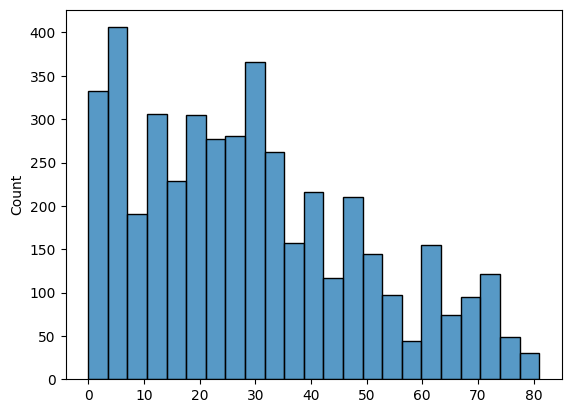

In [9]:
sns.histplot(train_df['loc_encoded'].values)

In [10]:
aod = test_df['aod'].values

In [11]:
def process_image(img):
    for band in range(13):
        for i in range(1,127):
            for j in range(1,127):
                if img[band,i,j] < 0:
                    print('12')
                    neighboring_pixels = img[band, i-1:i+2, j-1:j+2]
                    print(neighboring_pixels)
                    img[band,i,j] = (np.mean(neighboring_pixels[neighboring_pixels >= 0]))
    return img


In [12]:
import pywt

def wavelet_pansharpen(bands, wavelet='db1'):
    if not torch.cuda.is_available():
        raise RuntimeError("CUDA is not available. GPU cannot be used.")

    if bands.shape != (13, 128, 128):
        raise ValueError("Input bands should have shape (13, 128, 128)")

    bands_gpu = torch.from_numpy(bands).float().cuda()

    high_res_band = bands_gpu[7]

    pansharpened_bands = bands_gpu.clone()

    bands_to_pansharpen = [5, 6, 8, 11, 12]  

    for i in bands_to_pansharpen:
        low_res_band = bands_gpu[i]


        low_res_band_cpu = low_res_band.cpu().numpy()
        high_res_band_cpu = high_res_band.cpu().numpy()

        coeffs_low = pywt.dwt2(low_res_band_cpu, wavelet)
        coeffs_high = pywt.dwt2(high_res_band_cpu, wavelet)

        cA_low, (cH_low, cV_low, cD_low) = coeffs_low
        cA_high, (cH_high, cV_high, cD_high) = coeffs_high

        cA_combined = cA_low
        cH_combined = cH_high
        cV_combined = cV_high
        cD_combined = cD_high

        pansharpened = pywt.idwt2((cA_combined, (cH_combined, cV_combined, cD_combined)), wavelet)

        pansharpened = (pansharpened - pansharpened.min()) / (pansharpened.max() - pansharpened.min())
        pansharpened = pansharpened * (low_res_band_cpu.max() - low_res_band_cpu.min()) + low_res_band_cpu.min()

        pansharpened = np.clip(pansharpened, low_res_band_cpu.min(), low_res_band_cpu.max())

        pansharpened_bands[i] = torch.from_numpy(pansharpened).float().cuda()

    return pansharpened_bands.cpu().numpy()

In [13]:
bands = []
for i in tqdm(range(len(train_df))):
    path = str(train_df.path.values[i])
    pixels = rasterio.open("/home/modar/Compete/Data/" + path).read()
    #percent_positive = np.sum(pixels > 0, axis=(0,1, 2)) / (13 * 16384)
    #if (percent_positive >= 0.9):
    #    pixels = remove_haze(pixels)        /// Uncomment to use haze removal algorithm 
    #pixels = wavelet_pansharpen(pixels)    //// uncomment to pansharpen low resolution bands
    pixels = np.reshape(pixels,(13,128*128))
    pixels[pixels < 0] = 0
    bands.append(pixels)

100%|███████████████████████████████████████| 4465/4465 [00:58<00:00, 75.98it/s]


In [16]:
basic_bands = ['Aerosols'	,'Blue',	'Green' ,	'Red',	
               'Red_edge_1', 'Red_edge_2',	'Red_edge_3'	,'NIR',' Red_edge_4'	,'Water_vapor','SWIR1' ,	
               'SWIR2_' 	,'Aerosol_Optical_Thickness']

In [17]:
bands = np.array(bands)
means = np.mean(bands[:,0,:],axis=1)

bands.shape , means.shape , bands[:,0,:].shape


((4465, 13, 16384), (4465,), (4465, 16384))

In [ ]:
############################################################ EDA ###############################################################
#############################################################################################################################################################################################
#############################################################################################################################################################################################
#############################################################################################################################################################################################
#############################################################################################################################################################################################

In [19]:
full = []
full_idx = []
distorted_80 = []
distorted_60 = []
distorted_40 = []
distorted_20 = []
unusable = []
usable = []
usable_idx = []
for idx , band in enumerate(bands):
    percent_positive = np.min(np.sum(band > 0, axis=(1)) / (16384))
    if ((percent_positive >= 0.90) & (percent_positive <= 1)):
        usable.append(band)
        usable_idx.append(idx)
    if percent_positive == 1:
        full.append(band)
        full_idx.append(idx)
    elif ((percent_positive >= 0.8) & (percent_positive < 1)):
        distorted_80.append(band)
    elif ((percent_positive >= 0.6) & (percent_positive < 0.8)):
        distorted_60.append(band)
    elif ((percent_positive >= 0.4) & (percent_positive < 0.6)):
        distorted_40.append(band)
    elif ((percent_positive >= 0.2) & (percent_positive < 0.4)):
        distorted_20.append(band)
    elif percent_positive < 0.2:
        unusable.append(band)
        
full = np.array(full)
full_idx = np.array(full_idx)
usable = np.array(usable)
distorted_80 = np.array(distorted_80)
distorted_40 = np.array(distorted_40)
distorted_60 = np.array(distorted_60)
distorted_20 = np.array(distorted_20)
unusable = np.array(unusable)
full.shape , distorted_80.shape , distorted_60.shape , distorted_40.shape, distorted_20.shape , unusable.shape , usable.shape , full_idx.shape

((3904, 13, 16384),
 (271, 13, 16384),
 (156, 13, 16384),
 (18, 13, 16384),
 (100, 13, 16384),
 (16, 13, 16384),
 (4104, 13, 16384),
 (3904,))

In [20]:
B1 , B2 , B3 , B4 , B5 , B6 , B7 , B8 , B8A , B9 , B10 , B11 , B12 = [usable[:,i,:] for i in range(13)]

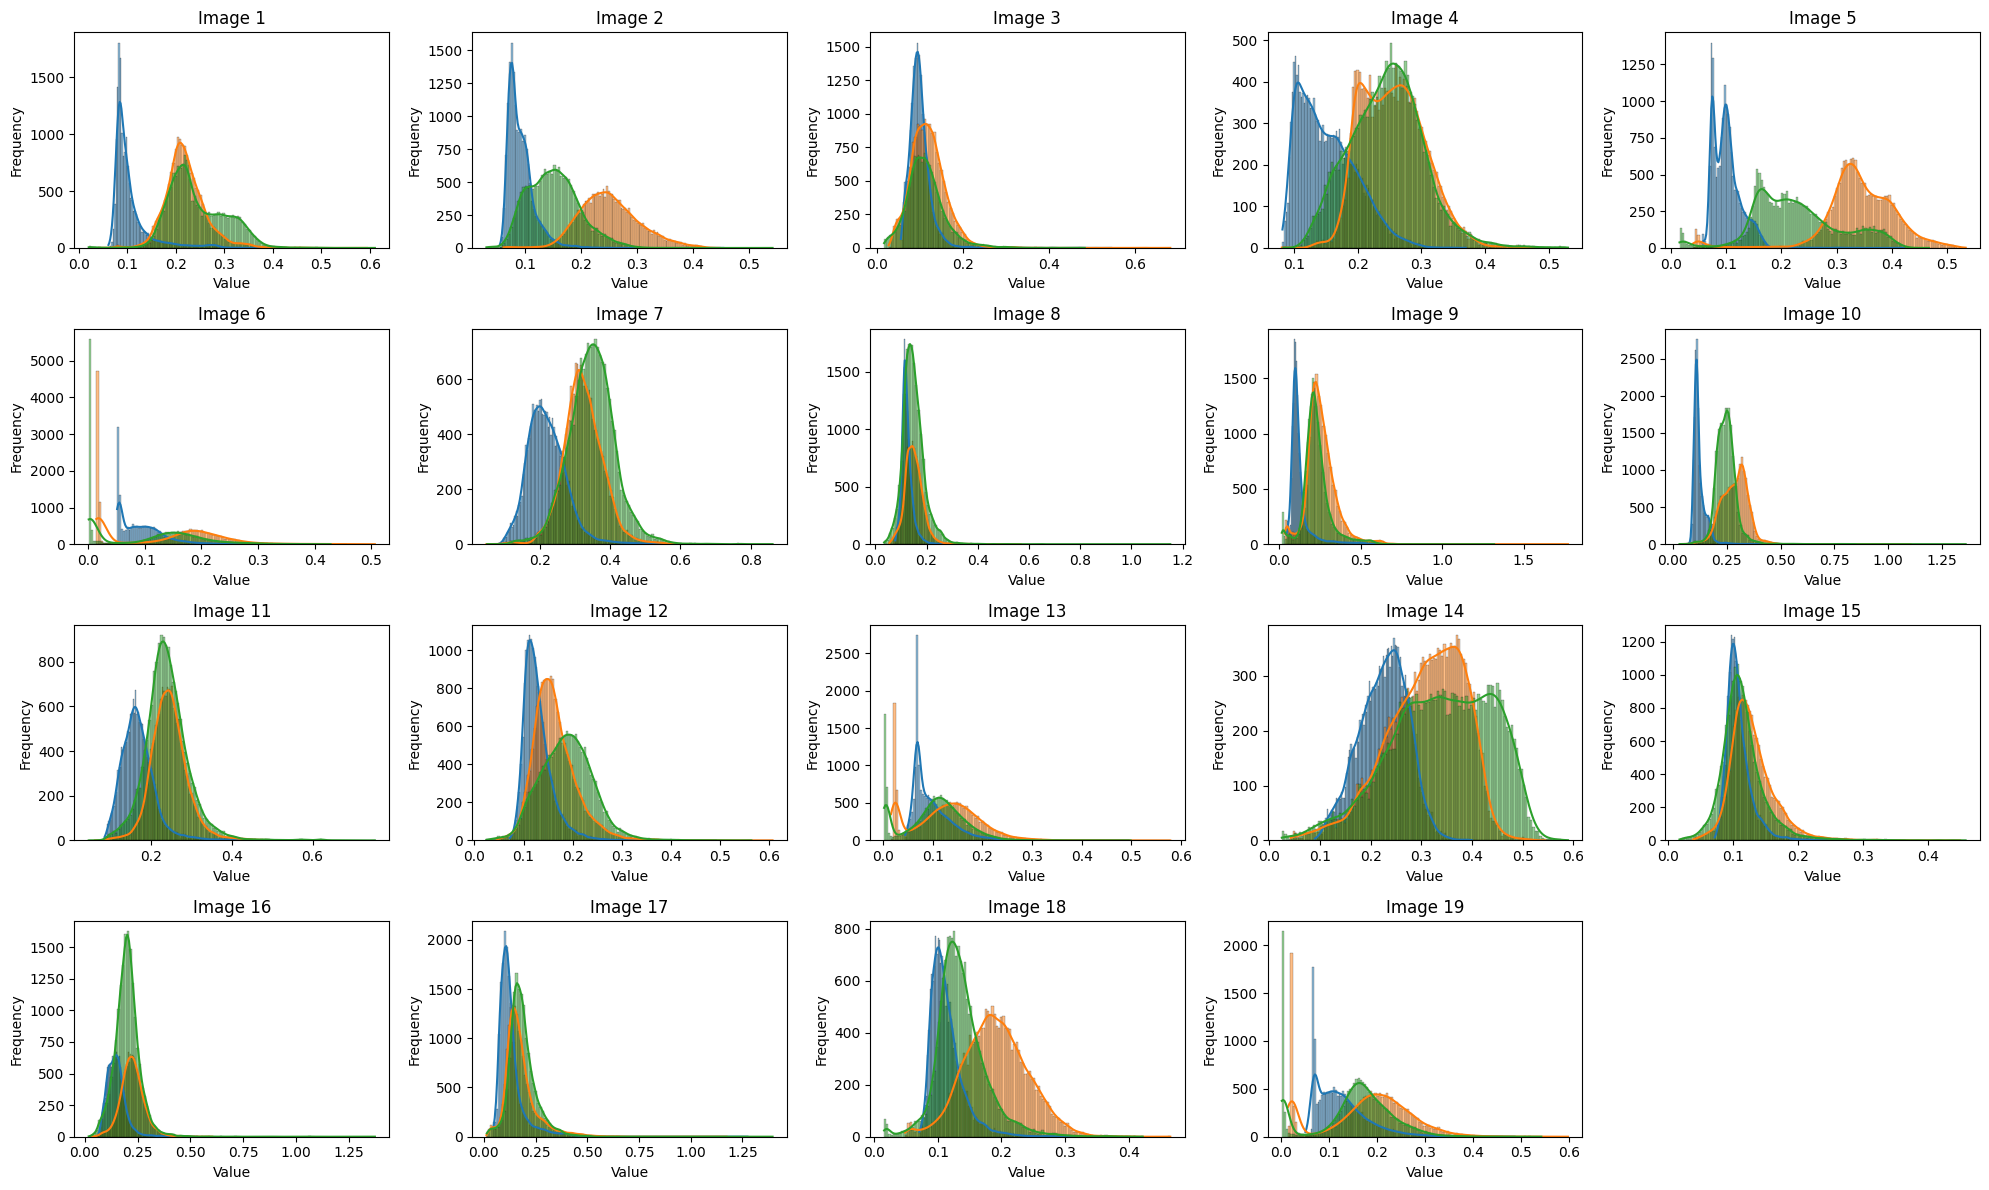

In [22]:
plt.figure(figsize=(20, 12))
for i in range(1, 20):
    plt.subplot(4, 5, i) 
    sns.histplot(B3[i-1], kde=True, bins=120)  
    sns.histplot(B7[i-1], kde=True, bins=120)  
    sns.histplot(B11[i-1], kde=True, bins=120)  
    plt.title(f'Image {i}') 
    plt.xlabel('Value')
    plt.ylabel('Frequency')


plt.tight_layout() 
plt.show()

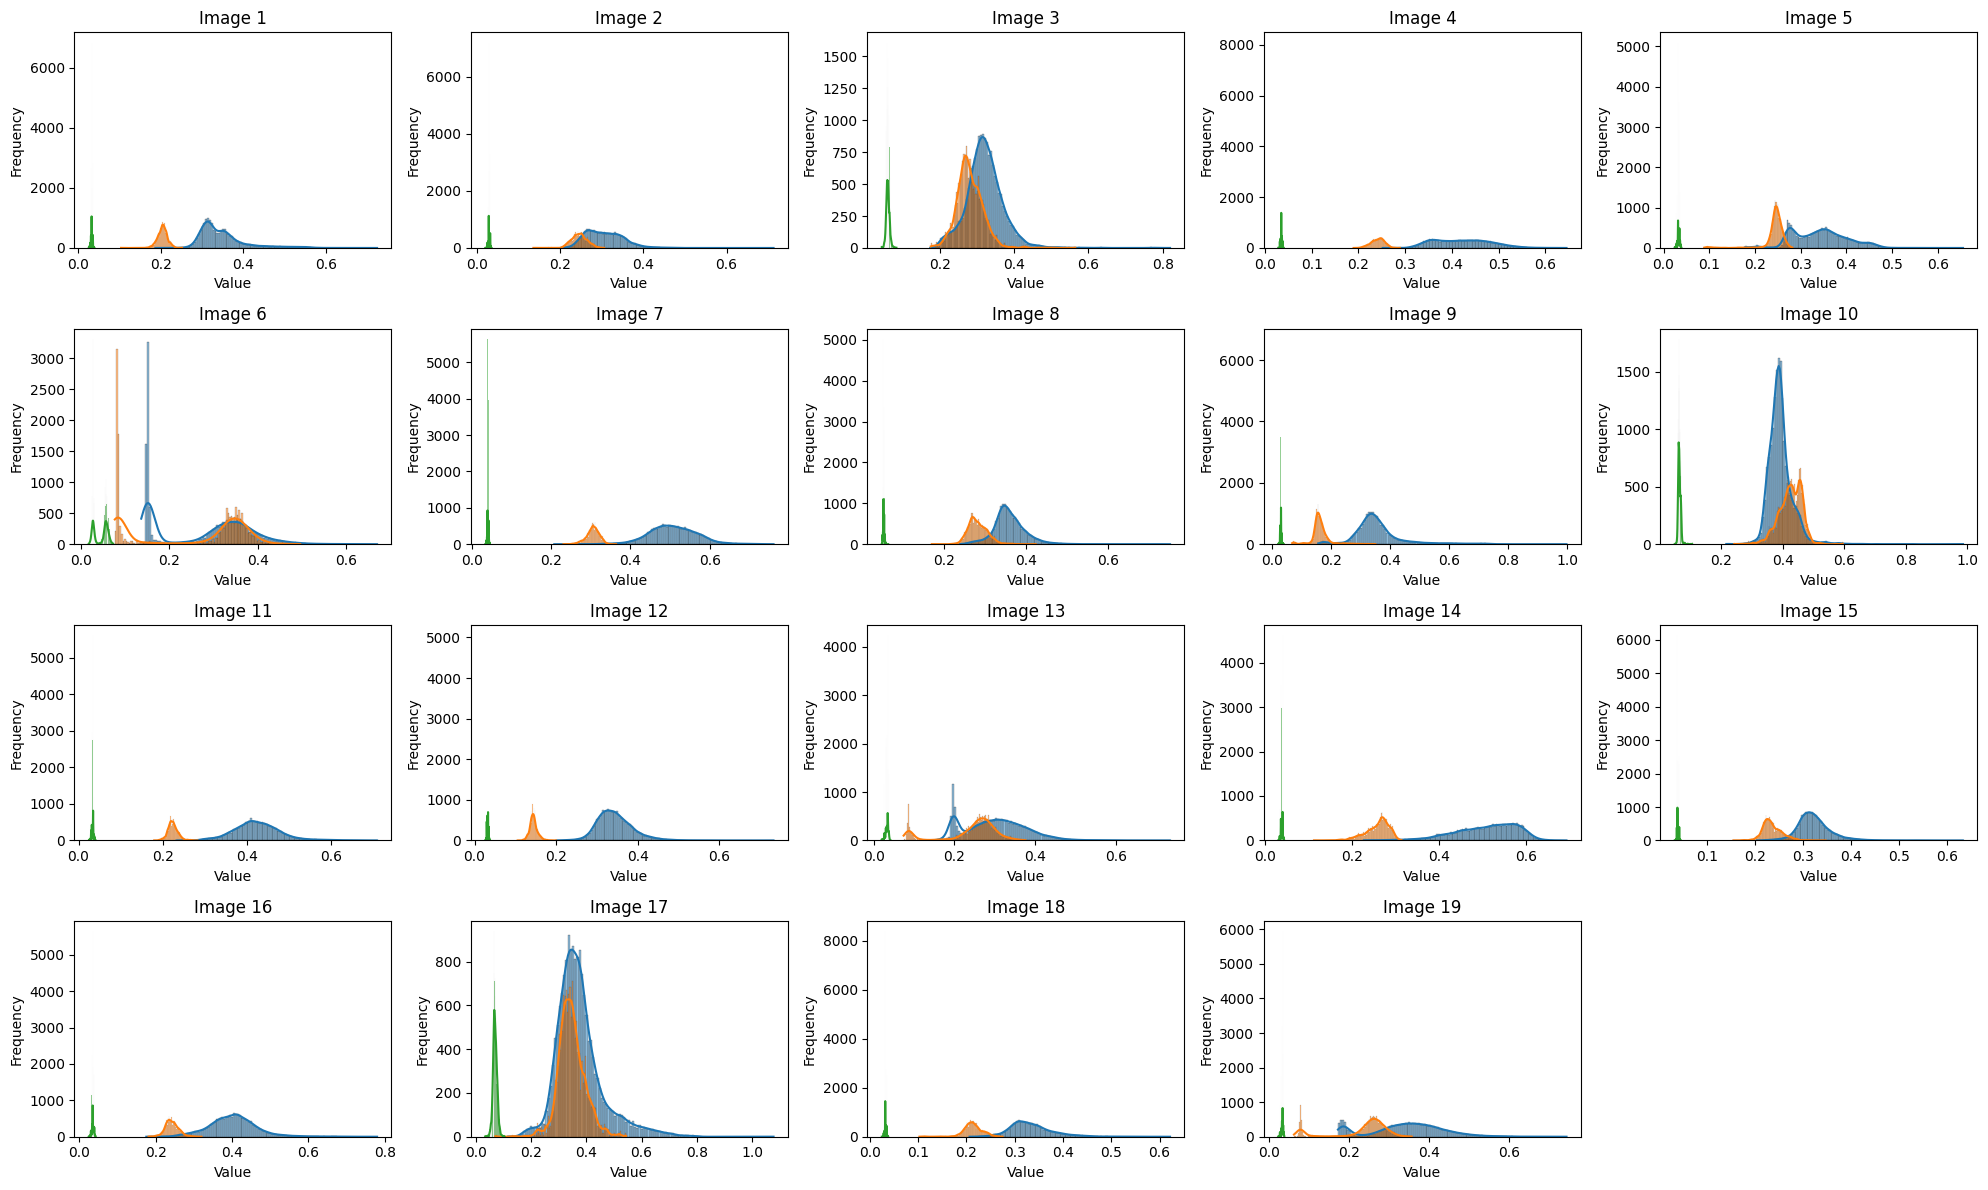

In [24]:
plt.figure(figsize=(20, 12))
for i in range(1, 20):
    plt.subplot(4, 5, i)
    sns.histplot(np.sqrt(B5[i-1]), kde=True, bins=120)  
    sns.histplot(np.sqrt(B9[i-1]), kde=True, bins=120)  
    sns.histplot(np.sqrt(B10[i-1]), kde=True, bins=120)  
    plt.title(f'Image {i}')  
    plt.xlabel('Value')
    plt.ylabel('Frequency')


plt.tight_layout()  
plt.show()

In [25]:
def create_rgb_image(img):
    img_reshaped = np.reshape(img,(13,128,128))
    B , G , R = img_reshaped[1,:,:] , img_reshaped[2,:,:] , img_reshaped[3,:,:]
    rgb_img = np.stack([R,G,B],axis=-1)
    return rgb_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0376..2.2446].


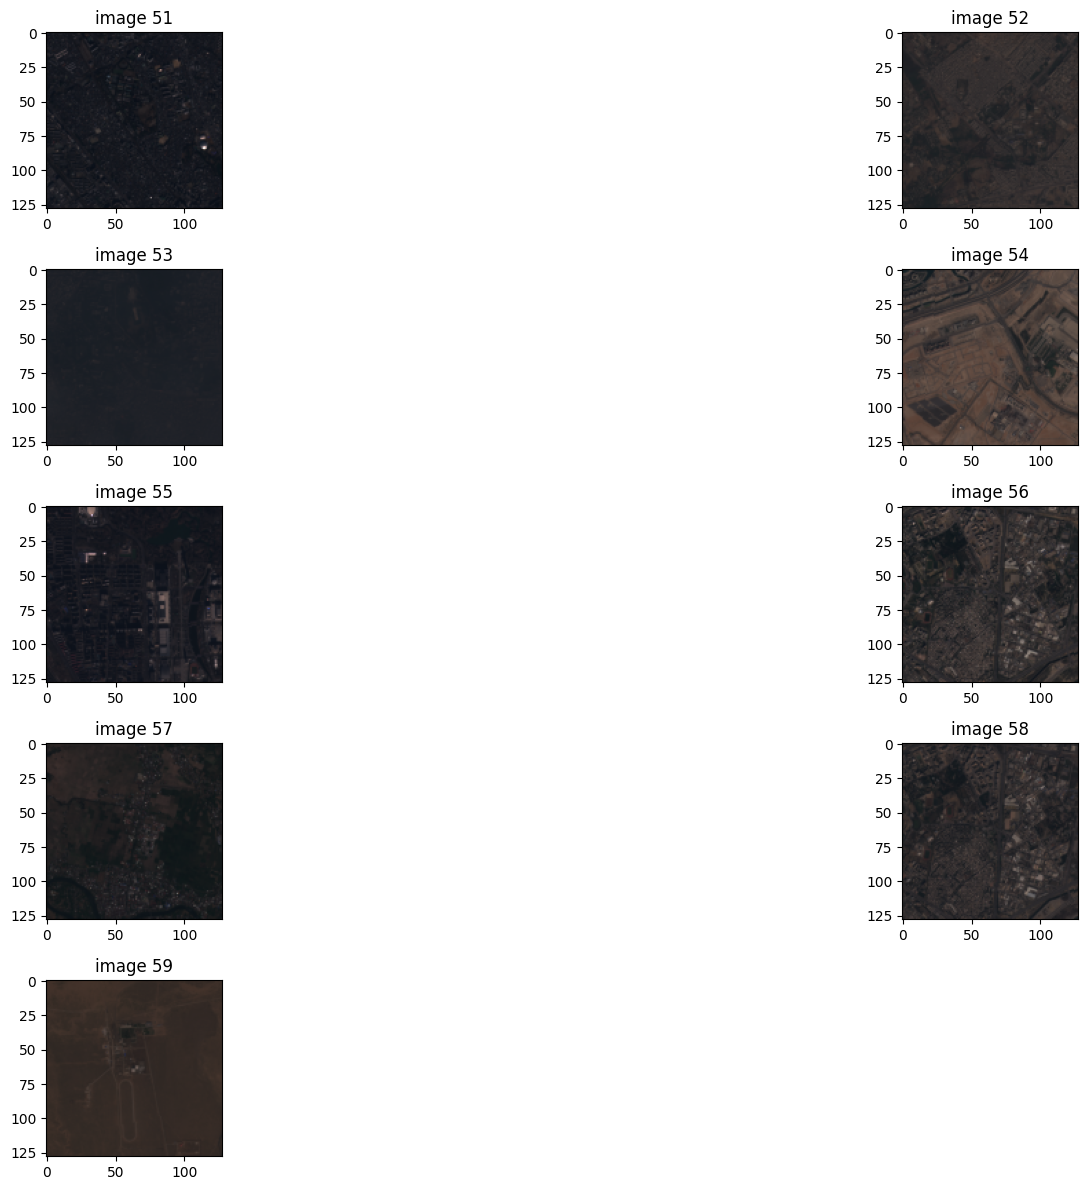

In [29]:
############ plot images with non-corrupted pixels

plt.figure(figsize=(20, 12))
for i in range(51,60):
    plt.subplot(5, 2, i-50)
    plt.imshow(create_rgb_image(full[i]))
    plt.title(f'image {i}')  


plt.tight_layout() 
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0395..1.9374].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0319..1.0177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3123].


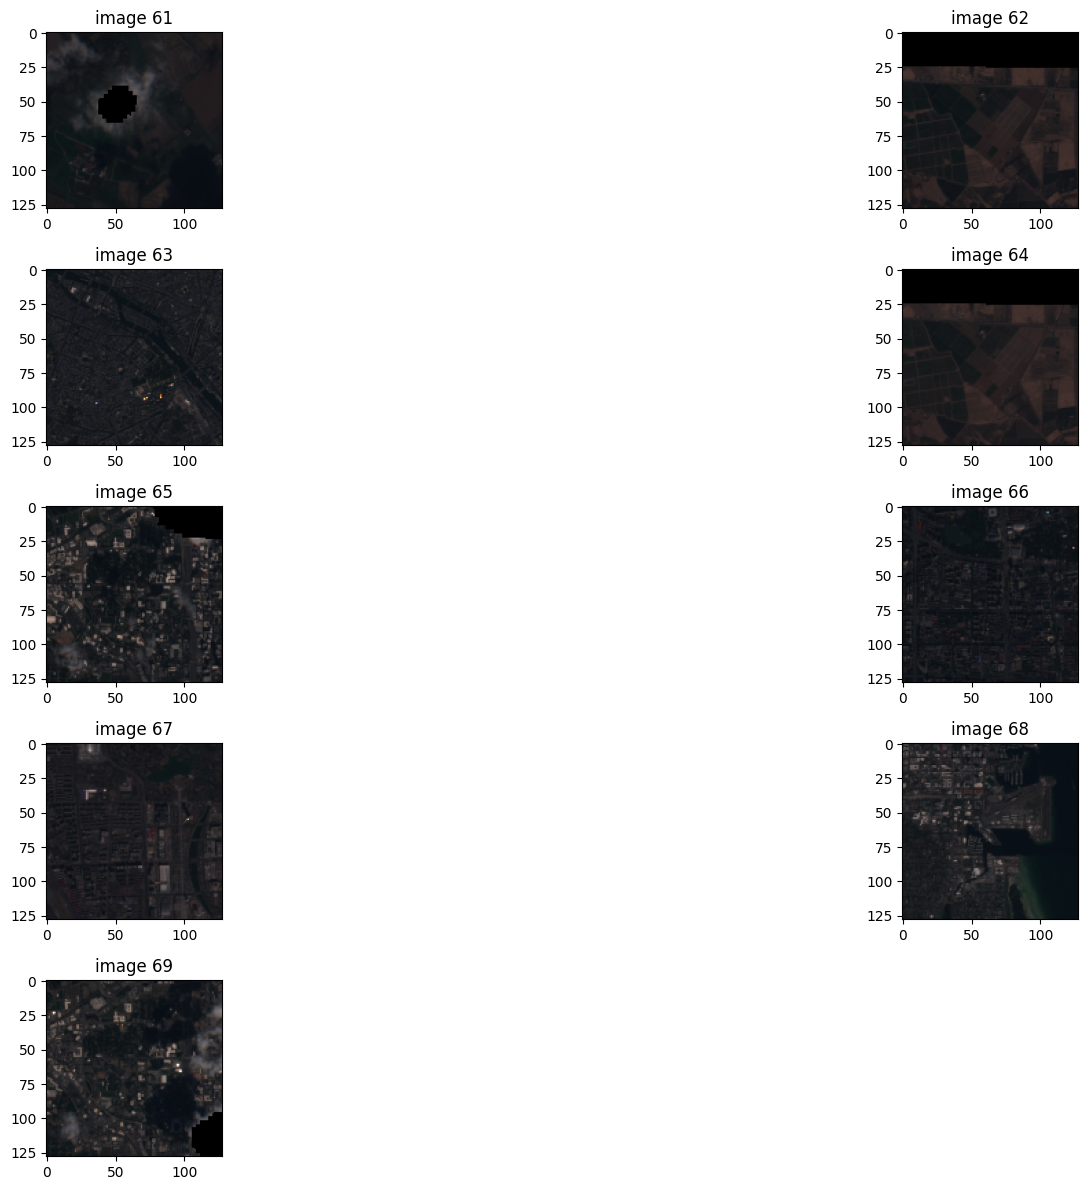

In [30]:
############ plot images with corrupted pixels 80%

plt.figure(figsize=(20, 12))
for i in range(61,70):
    plt.subplot(5, 2, i-60)  
    plt.imshow(create_rgb_image(distorted_80[i]))
    plt.title(f'image {i}')  


plt.tight_layout()  
plt.show()

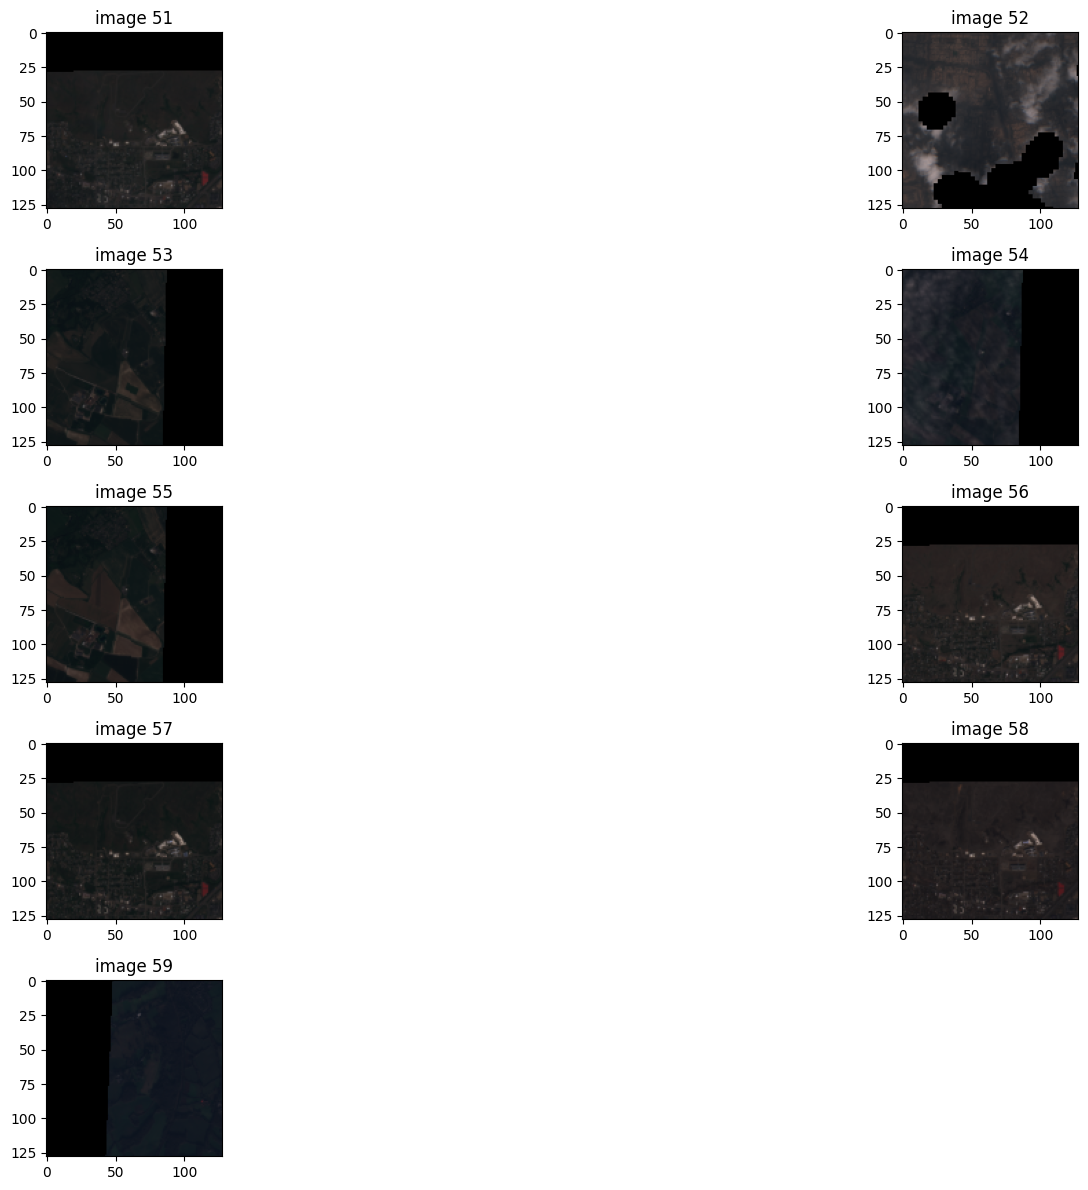

In [31]:
############ plot images with corrupted pixels 60%

plt.figure(figsize=(20, 12))
for i in range(51,60):
    plt.subplot(5, 2, i-50) 
    plt.imshow(create_rgb_image(distorted_60[i]))
    plt.title(f'image {i}')  


plt.tight_layout()  
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0052].


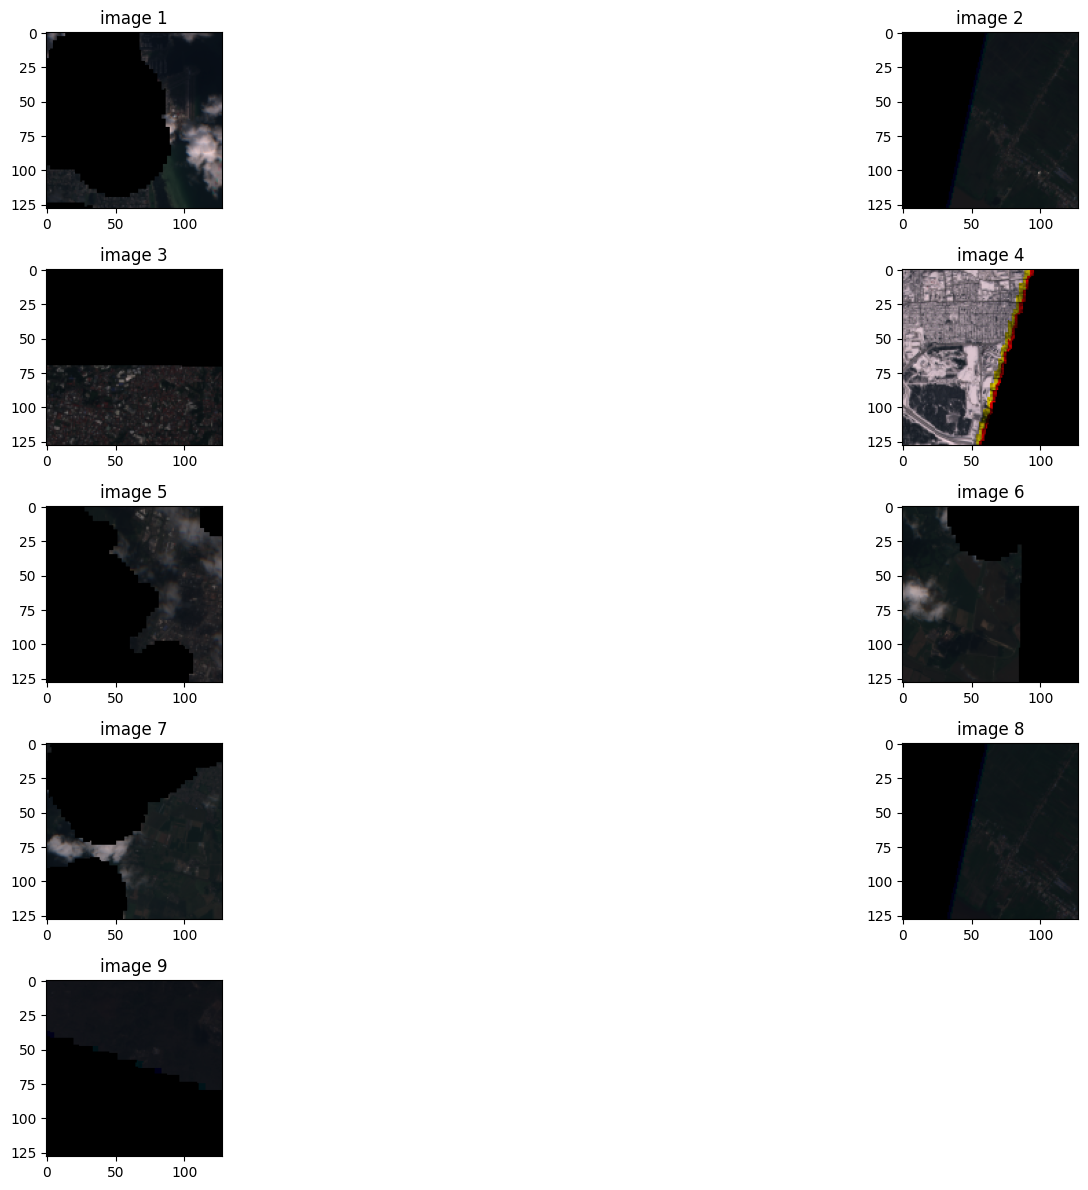

In [32]:
############ plot images with corrupted pixels 40%

plt.figure(figsize=(20, 12))
for i in range(1,10):
    plt.subplot(5, 2, i) 
    plt.imshow(create_rgb_image(distorted_40[i]))
    plt.title(f'image {i}') 


plt.tight_layout()  
plt.show()

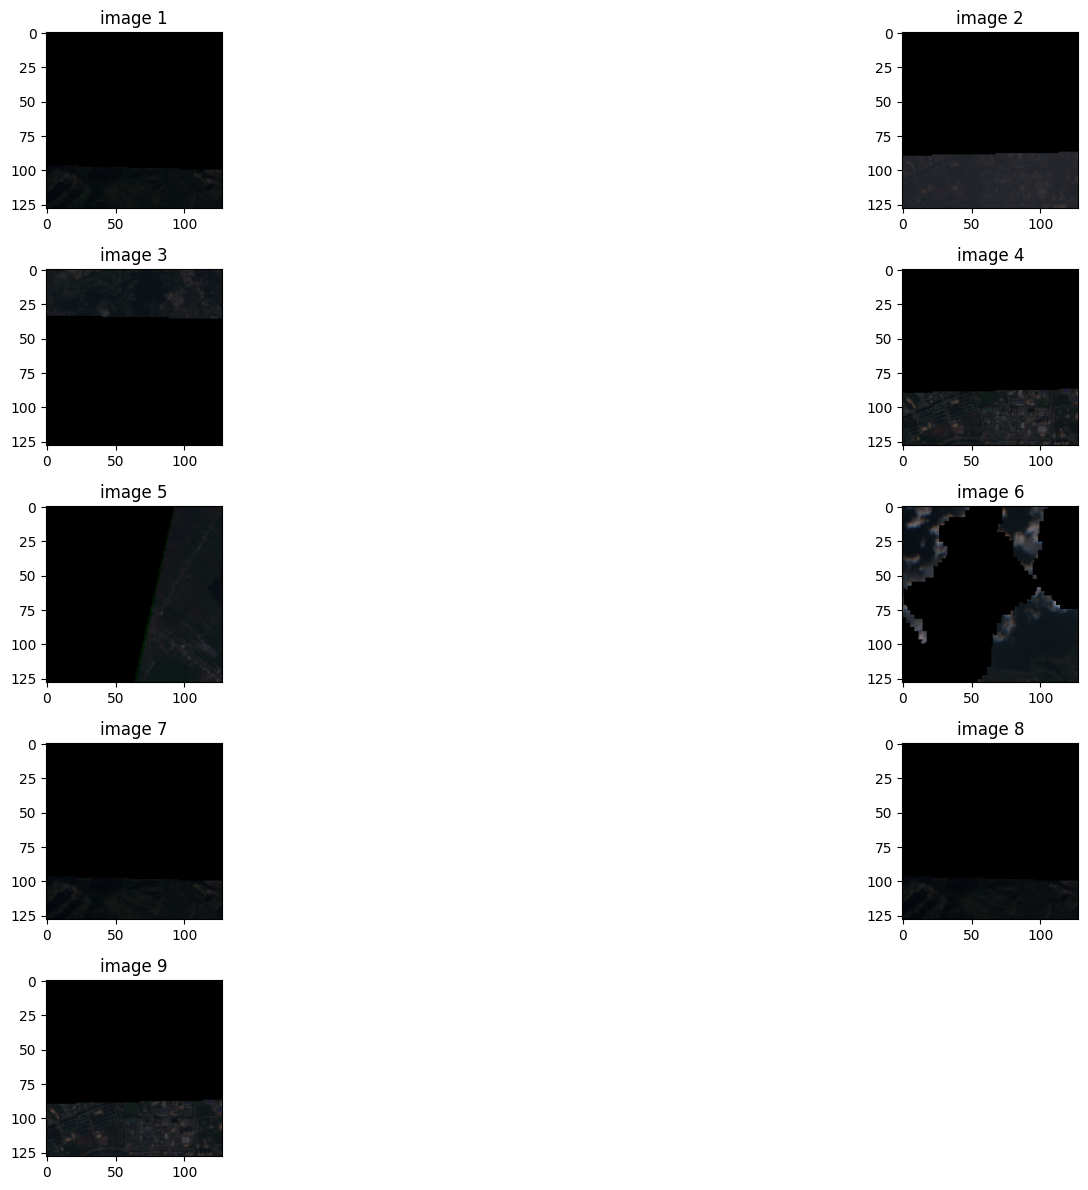

In [33]:
############ plot images with corrupted pixels 20%

plt.figure(figsize=(20, 12))
for i in range(1,10):
    plt.subplot(5, 2, i)  
    plt.imshow(create_rgb_image(distorted_20[i]))
    plt.title(f'image {i}')  


plt.tight_layout()
plt.show()

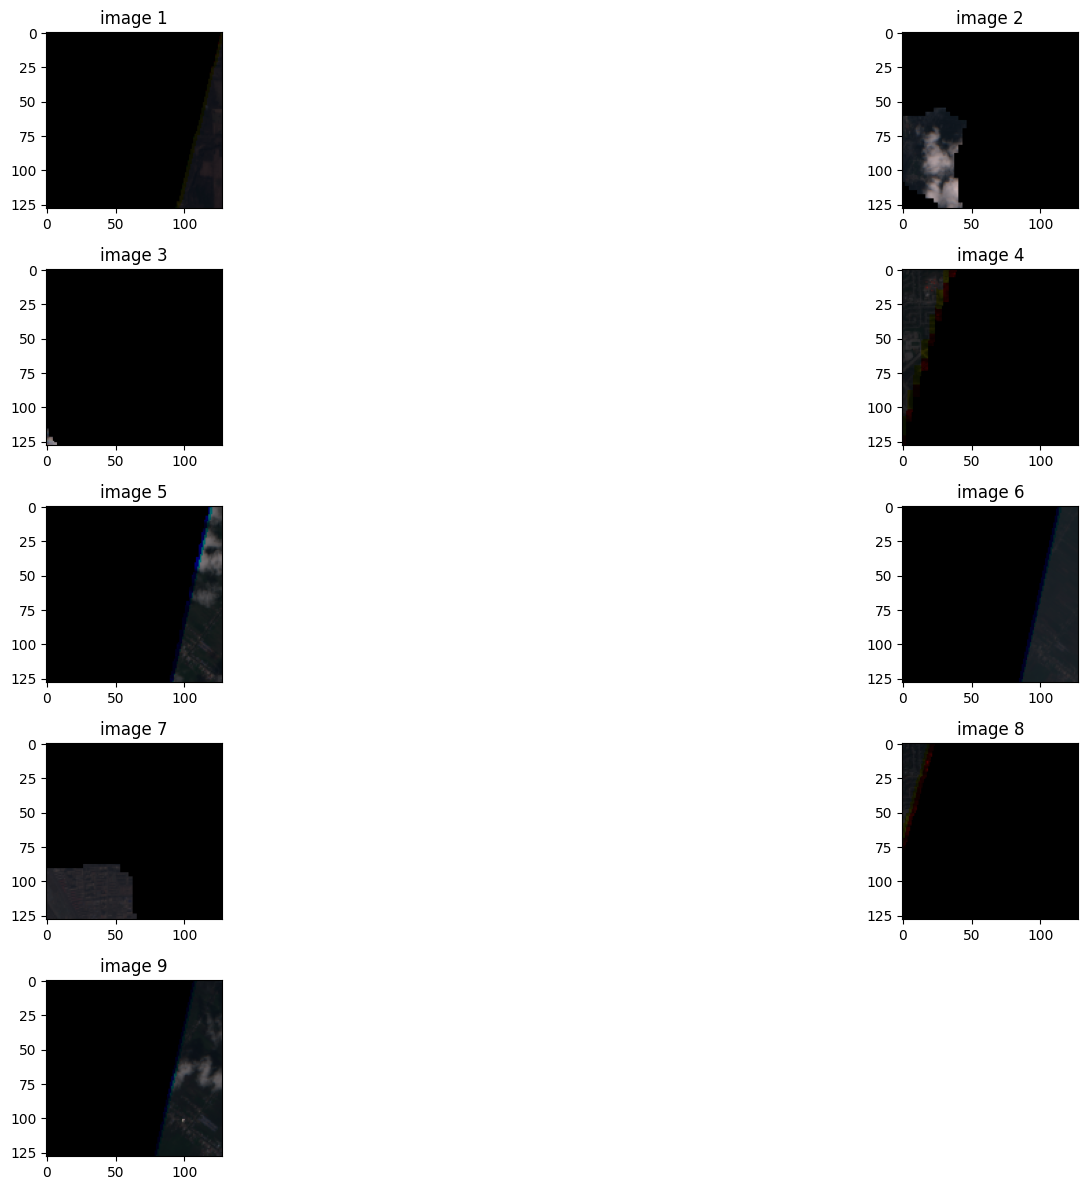

In [34]:
############ plot images with corrupted pixels 0%

plt.figure(figsize=(20, 12))
for i in range(1,10):
    plt.subplot(5, 2, i)  
    plt.imshow(create_rgb_image(unusable[i]))
    plt.title(f'image {i}') 


plt.tight_layout()  
plt.show()

In [37]:

def smooth_edges(img, mask):
    img_new = img.copy()
    kernel_size = 5 
    edges = cv2.Canny(mask.astype(np.uint8) * 255, 100, 200)  

    edge_mask = (edges > 0).astype(np.uint8)

    smoothed_edges = cv2.GaussianBlur(img_new, (kernel_size, kernel_size), sigmaX=2)

    img_new[edge_mask == 1] = smoothed_edges[edge_mask == 1]
    
    return img_new


def crop_random_area(img, mask, patch_size=32):
    h, w, _ = img.shape
    filled_mask = mask.copy() * 0
    img_new = img.copy()
    masked_indices = np.argwhere(mask == 1)
    random.shuffle(masked_indices)
        
    def get_random_patch():
        unmasked_indices = np.argwhere(mask == 0)
        for _ in range(100):
            if unmasked_indices.size == 0:
                return None
            idx = random.choice(unmasked_indices)
            x, y = idx
            
            if x + patch_size <= h and y + patch_size <= w:
                patch_mask = mask[x:x + patch_size, y:y + patch_size]
                #if np.all(patch_mask == 0):
                if np.sum(patch_mask) != patch_mask.shape[0] * patch_mask.shape[1]:
                    return img_new[x:x + patch_size, y:y + patch_size]
        return None

    def place_patch(i, j, patch):
        for x in range(i, i + patch.shape[0]):
            for y in range(j, j + patch.shape[1]):
                if mask[x, y] == 1 and filled_mask[x, y] == 0:
                    #if img_new[x, y].any() > 0:  
                    #    return  
                    #blend_factor = weight_mask[x - i, y - j]
                    #img_new[x, y] = (1 - blend_factor) * img_new[x, y] + blend_factor * patch[x - i, y - j]
                    #filled_mask[x, y] = 1
                    
                    img_new[x, y] = patch[x - i, y - j]
                    filled_mask[x, y] = 1
                    
    
    for i, j in masked_indices:
        bottom_right_i = i + patch_size
        bottom_right_j = j + patch_size
        
        clipped_bottom_right_i = min(bottom_right_i, h)
        clipped_bottom_right_j = min(bottom_right_j, w)
    
        height = clipped_bottom_right_i - i
        width = clipped_bottom_right_j - j
        
        if (filled_mask[i:clipped_bottom_right_i, j:clipped_bottom_right_j].sum() != filled_mask.shape[0] * filled_mask.shape[1]):
            patch = get_random_patch()
            if patch is not None:
                resized_patch = patch[:height, :width]
                place_patch(i, j, resized_patch)

    if np.any(filled_mask[mask == 1] == 0):
        print("Some masked areas are still unfilled.")
    return img_new

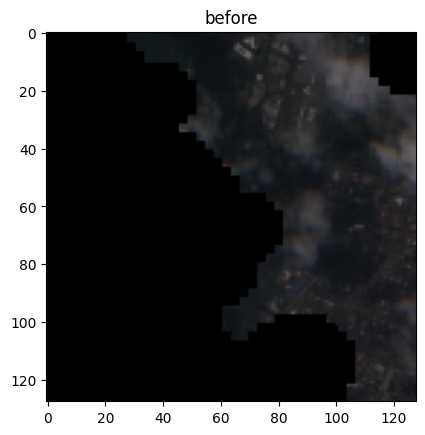

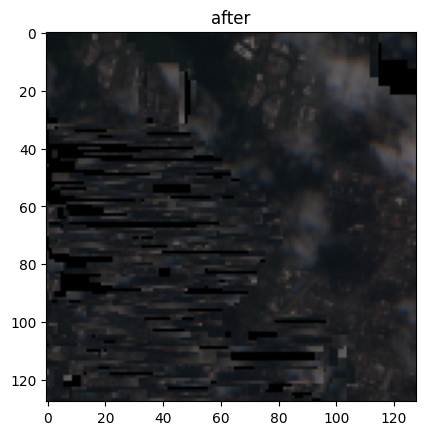

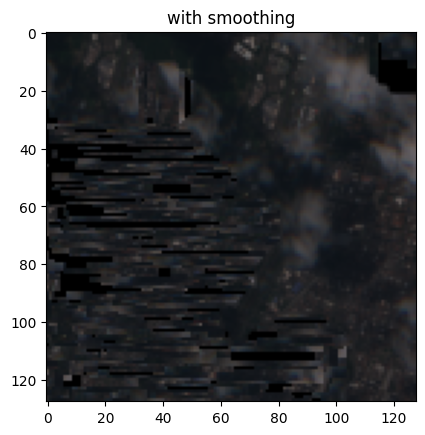

array([[[0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    ],
        ...,
        [0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    ]],

       [[0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    ],
        ...,
        [0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    ]],

       [[0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    ],
        ...,
        [0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    ]],

       ...,

       [[0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    ],
        ...,
        [0.0875, 0.093 , 0.1113],
        [0.1172, 0.1192, 0.1312],
        [0.0881, 0.094 , 0.1088]],

       [[0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    ],
        .

In [40]:
""""
This section plots the resulted image of filling corrupted pixels with cropped patches
"""
import random

iimg = create_rgb_image(distorted_40[5])
mask = ( (iimg[:,:,0] <= 0) )
mask = np.array(mask,dtype=np.uint8)
iimg_fill = crop_random_area(iimg,mask)
smooth_image = smooth_edges(iimg_fill, mask)
plt.title(f'before')
plt.imshow(iimg)
plt.show()
plt.title(f'after')
plt.imshow(iimg_fill)
plt.show()
plt.title(f'with smoothing')
plt.imshow(smooth_image)
plt.show()
iimg

In [ ]:
"""""
This part of the code was used to investigate which strategy is best when filling nan values in the image (zeros, mean value, median)
the arrays were generated by masking some part of the image, then measuring the cosine similarity with the original image for each method
""""
def cosine_similarity(img1, img2, epsilon=1e-10):
    img1 = img1.flatten()
    img2 = img2.flatten()
    dot_product = np.dot(img1, img2)
    norm_img1 = np.linalg.norm(img1)
    norm_img2 = np.linalg.norm(img2)
    similarity = dot_product / (norm_img1 * norm_img2 + epsilon)
    
    return similarity
idx = 1
plt.title('All')
sns.kdeplot(np.reshape(rgb[:,:,idx],(128*128)),label='original')
sns.kdeplot(np.reshape(rgb_partial[:,:,idx],(128*128)),label='zero')
sns.kdeplot(np.reshape(rgb_mean[:,:,idx],(128*128)),label='mean')
sns.kdeplot(np.reshape(rgb_median[:,:,idx],(128*128)),label='median')

plt.legend()
plt.show()
print('Image name: original            zero                mean                median')
print(f'Means are {np.mean(rgb[:,:,idx],axis=(0,1))} , {np.mean(rgb_partial[:,:,idx],axis=(0,1))} , {np.mean(rgb_mean[:,:,idx],axis=(0,1)) } , {np.mean(rgb_median[:,:,idx],axis=(0,1))}')
print(f'stds are {np.std(rgb[:,:,idx],axis=(0,1))} , {np.std(rgb_partial[:,:,idx],axis=(0,1))} , {np.std(rgb_mean[:,:,idx],axis=(0,1)) } , {np.std(rgb_median[:,:,idx],axis=(0,1)) }')
print(f'skew are {skew(rgb[:,:,idx],axis=(0,1))} , {skew(rgb_partial[:,:,idx],axis=(0,1))} , {skew(rgb_mean[:,:,idx],axis=(0,1)) }  ,  {skew(rgb_median[:,:,idx],axis=(0,1)) }')

print(f'mean sm {np.mean(rgb[:,:,idx],axis=(0,1)) - np.mean(rgb[:,:,idx],axis=(0,1))} , {np.mean(rgb_partial[:,:,idx],axis=(0,1)) - np.mean(rgb[:,:,idx],axis=(0,1))} , {np.mean(rgb_mean[:,:,idx],axis=(0,1)) - np.mean(rgb[:,:,idx],axis=(0,1)) } , {np.mean(rgb_median[:,:,idx],axis=(0,1)) - np.mean(rgb[:,:,idx],axis=(0,1)) }')
print(f'std sm {np.std(rgb[:,:,idx],axis=(0,1)) - np.std(rgb[:,:,idx],axis=(0,1))} , {np.std(rgb_partial[:,:,idx],axis=(0,1)) - np.std(rgb[:,:,idx],axis=(0,1))} , {np.std(rgb_mean[:,:,idx],axis=(0,1)) - np.std(rgb[:,:,idx],axis=(0,1)) } , {np.std(rgb_median[:,:,idx],axis=(0,1)) - np.std(rgb[:,:,idx],axis=(0,1)) }')
print(f'cosine sm {cosine_similarity(rgb,rgb)}  , {cosine_similarity(rgb,rgb_partial)}  ,   {cosine_similarity(rgb,rgb_mean)}   ,   {cosine_similarity(rgb,rgb_median)} ')

rmse_zero = np.sqrt(np.mean((rgb[:,:,idx] - rgb_partial[:,:,idx]) ** 2))
rmse_mean = np.sqrt(np.mean((rgb[:,:,idx] - rgb_mean[:,:,idx]) ** 2))
rmse_median = np.sqrt(np.mean((rgb[:,:,idx] - rgb_median[:,:,idx]) ** 2))
print(f'RMSE: zero = {rmse_zero}, mean = {rmse_mean}, median = {rmse_median}')

In [ ]:
#######################################################################################################################################################################################
#############################################################################################################################################################################################
#############################################################################################################################################################################################
#############################################################################################################################################################################################
#############################################################################################################################################################################################

In [44]:
epsilon = 1e-6

def read_image(path):
    image = rasterio.open("/home/modar/Compete/Data/" + path).read()
    image = np.reshape(image, (13, 128 * 128))

    corrupted_mask = (image < 0) | (image > 1)
    
    image[corrupted_mask] = 0

    return image

def calculate_statistics(basic_bands, df, bands):
    
    new_cols = {}
    for j, band in enumerate(tqdm(basic_bands)):
        
        new_cols[str(band) + '_mean'] = np.mean(bands[:,j,:],axis=1)
        new_cols[str(band) + '_var'] = np.var(bands[:,j,:],axis=1)
        new_cols[str(band) + '_median'] = np.median(bands[:,j,:],axis=1)
        new_cols[str(band) + '_kurtosis'] = kurtosis(bands[:,j,:],axis=1)
        new_cols[str(band) + '_skew'] = skew(bands[:,j,:],axis=1)
        new_cols[str(band) + '_std'] = np.std(bands[:,j,:],axis=1)
        new_cols[str(band) + '_p10'] = np.percentile(bands[:,j,:], 10,axis=1)
        new_cols[str(band) + '_p25'] = np.percentile(bands[:,j,:], 25,axis=1)
        new_cols[str(band) + '_p75'] = np.percentile(bands[:,j,:], 75,axis=1)
        new_cols[str(band) + '_p90'] = np.percentile(bands[:,j,:],90,axis=1)
    
    for (i, j) in tqdm(itertools.combinations(range(len(basic_bands)), 2)):  
            Ba = bands[:,i,:]
            Bb = bands[:,j,:]
            new_band = (Ba - Bb) / (Ba + Bb + epsilon)

            new_cols[f'band_{i}_{j}_mean'] = (np.mean(new_band))
            new_cols[f'band_{i}_{j}_median'] = (np.median(new_band))
            new_cols[f'band_{i}_{j}_var'] = (np.var(new_band))
            new_cols[f'band_{i}_{j}_kurtosis'] = kurtosis(new_band,axis=1)
            new_cols[f'band_{i}_{j}_skew'] = skew(new_band,axis=1)
            new_cols[f'band_{i}_{j}_std'] = (np.std(new_band))
            new_cols[f'band_{i}_{j}_10th_percentile'] = (np.percentile(new_band, 10,axis=1))
            new_cols[f'band_{i}_{j}_25th_percentile'] = (np.percentile(new_band, 25,axis=1))
            new_cols[f'band_{i}_{j}_75th_percentile'] = (np.percentile(new_band, 75,axis=1))
            new_cols[f'band_{i}_{j}_90th_percentile'] = (np.percentile(new_band, 90,axis=1))
        
    for (i, j) in tqdm(itertools.combinations(range(len(basic_bands)), 2)):  
            Ba = bands[:,i,:]
            Bb = bands[:,j,:]
            new_band = (Ba) / (Bb + epsilon)

            new_cols[f'band_{i}_{j}_mean'] = (np.mean(new_band))
            new_cols[f'band_{i}_{j}_median'] = (np.median(new_band))
            new_cols[f'band_{i}_{j}_var'] = (np.var(new_band))
            new_cols[f'band_{i}_{j}_kurtosis'] = kurtosis(new_band,axis=1)
            new_cols[f'band_{i}_{j}_skew'] = skew(new_band,axis=1)
            new_cols[f'band_{i}_{j}_std'] = (np.std(new_band))
            new_cols[f'band_{i}_{j}_10th_percentile'] = (np.percentile(new_band, 10,axis=1))
            new_cols[f'band_{i}_{j}_25th_percentile'] = (np.percentile(new_band, 25,axis=1))
            new_cols[f'band_{i}_{j}_75th_percentile'] = (np.percentile(new_band, 75,axis=1))
            new_cols[f'band_{i}_{j}_90th_percentile'] = (np.percentile(new_band, 90,axis=1))
    
    
    df = pd.concat([df, pd.DataFrame(new_cols)], axis=1)
    
    return df

def calculate_advanced_band_features(basic_bands, df, bands, epsilon=1e-9):

    new_cols = {}
    
    for (i, j) in tqdm(itertools.combinations(range(len(basic_bands)), 2)):
        Ba = bands[:, i, :]
        Bb = bands[:, j, :]
        
        new_cols[f'band_{i}_{j}_geometric_mean'] = np.sqrt(Ba * Bb).mean(axis=1)
        
        new_cols[f'band_{i}_{j}_harmonic_mean'] = (2 * Ba * Bb / (Ba + Bb + epsilon)).mean(axis=1)
        
        new_cols[f'band_{i}_{j}_normalized_ratio'] = ((Ba - Bb) / (np.sqrt(Ba**2 + Bb**2) + epsilon)).mean(axis=1)
    
    for i, band in tqdm(enumerate(basic_bands)):
        Ba = bands[:, i, :]

        new_cols[f'band_{i}_entropy'] = np.apply_along_axis(lambda x: entropy(np.histogram(x, bins=256, density=True)[0]), 1, Ba)

    for (i, j, k) in tqdm(itertools.combinations(range(len(basic_bands)), 3)):
        Ba = bands[:, i, :]
        Bb = bands[:, j, :]
        Bc = bands[:, k, :]
        
        new_cols[f'band_{i}_{j}_{k}_diff_prod'] = ((Ba * Bb) - (Ba * Bc)).mean(axis=1)

    for (i, j, k) in tqdm(itertools.combinations(range(len(basic_bands)), 3)):
        Ba = bands[:, i, :]
        Bb = bands[:, j, :]
        Bc = bands[:, k, :]
        
        new_cols[f'band_{i}_{j}_{k}_custom_ratio'] = ((Ba * Bb) / (Bc + epsilon)).mean(axis=1)

    df = pd.concat([df, pd.DataFrame(new_cols)], axis=1)
    
    return df


def compute_texture_features(basic_bands,df,bands):

    new_cols = {band: {f'{band}_contrast': [], f'{band}_correlation': [], 
                       f'{band}_energy': [], f'{band}_homogeneity': [], f'{band}_GLCM_Dissimilarity': [],f'{band}_Homogeneity':[]}
                for band in basic_bands}
    for band in basic_bands:
        print(f'{band}_GLCM_Dissimilarity')
    for i in range(bands.shape[0]):

        for j, band in enumerate(basic_bands):

            reshaped_band = bands[i, j, :].reshape(128, 128)
            
            glcm = graycomatrix(reshaped_band.astype(np.uint8), distances=[1], angles=[0], symmetric=True, normed=True)
            new_cols[band][f'{band}_GLCM_Dissimilarity'].append(graycoprops(glcm, 'dissimilarity')[0, 0])
            new_cols[band][f'{band}_Homogeneity'].append(graycoprops(glcm, 'homogeneity')[0, 0])
            new_cols[band][f'{band}_contrast'].append(graycoprops(glcm, 'contrast')[0, 0])
            new_cols[band][f'{band}_correlation'].append(graycoprops(glcm, 'correlation')[0, 0])
            new_cols[band][f'{band}_energy'].append(graycoprops(glcm, 'energy')[0, 0])
            new_cols[band][f'{band}_homogeneity'].append(graycoprops(glcm, 'homogeneity')[0, 0])
    
    for band in basic_bands:
        df_band = pd.DataFrame(new_cols[band])
        df = pd.concat([df, df_band], axis=1)
    
    return df
    
def calculate_vegetation_indices(df, bands):

        new_cols = {}
        B1 = bands[:, 0, :]
        B2 = bands[:, 1, :]
        B3 = bands[:, 2, :]
        B4 = bands[:, 3, :]
        B5 = bands[:, 4, :]
        B6 = bands[:, 5, :]
        B7 = bands[:, 6, :]
        B8 = bands[:, 7, :]
        B8A = bands[:, 8, :]
        B9 = bands[:, 9, :]
        B11 = bands[:, 10, :]
        B12 = bands[:, 11, :]
        
        ndvi = (B8 - B4) / (B8 + B4 + epsilon)
        
        gli = (2 * B3 - B4 - B2) / (2 * B3 + B4 + B2 + epsilon)
        
        cvi = (B8 * B4) / (B3**2 + epsilon)  
        
        sipi = (B8 - B2) / (B8 - B4 + epsilon) 
        
        ndwi = (B8 - B11) / (B8 + B11 + epsilon)  
    
        ccci = (B8 - B5) / (B8 + B5 + epsilon) / (B8 - B4 + epsilon) / (B8 + B4 + epsilon)
        
        hue = np.arctan2((B2 - B3), (B3 - B4))
        
        rendvi = (B6 - B5) / (B6 + B5 + epsilon)
        
        reci = (B8 / (B4 + epsilon)) - 1
        
        evi = 2.5 * (B8 - B4) / (B8 + 6 * B4 - 7.5 * B2 + 1.0 + epsilon)
        
        evi2 = 2.4 * (B8 - B4) / (B8 + B4 + 1.0 + epsilon)
        
        bsi = (B11 + B4) / (B8 + B2 + epsilon)  
    
        npcri = (B3 - B8) / (B3 + B8 + epsilon)
        
        mndvi = (B8 - B4) / (B8 + B4 - 2 * B2 + epsilon)
        
        ndsi = (B3 - B11) / (B3 + B11 + epsilon)
        
        ndmi = (B8 - B11) / (B8 + B11 + epsilon)
        
        ndbi = (B11 - B8) / (B11 + B8 + epsilon)
        
        ndci = (B5 - B4) / (B5 + B4 + epsilon)
        
        gndvi = (B8 - B3) / (B8 + B3 + epsilon)
        
        L = 0.428
        savi = ((B1 - B2) / (B1 + B2 + L + epsilon)) * (1.0 + L)
        
        #####
        vegetation_bands = {
            'ndvi': ndvi, 'gli': gli, 'cvi': cvi, 'sipi': sipi, 'ccci': ccci,
            'hue': hue, 'rendvi': rendvi, 'reci': reci, 'evi': evi, 'evi2': evi2, 'ndwi': ndwi,
            'npcri': npcri, 'mndvi': mndvi, 'ndsi': ndsi, 'ndmi': ndmi, 'ndbi': ndbi, 'ndci': ndci,
            'gndvi': gndvi, 'savi': savi, 'bsi': bsi
        }


        glcm_features = {f'{name}_GLCM_{prop}': [] for name in vegetation_bands for prop in ['Dissimilarity', 'Homogeneity', 'Contrast', 'Correlation', 'Energy']}
        for vegetation_band_name , vegetation_band_vals in tqdm(vegetation_bands.items()):
            
            new_cols[str(vegetation_band_name) + '_mean'] = np.mean(vegetation_band_vals,axis=1)
            new_cols[str(vegetation_band_name) + '_mean'] = np.mean(vegetation_band_vals,axis=1)
            new_cols[str(vegetation_band_name) + '_var'] = np.var(vegetation_band_vals,axis=1)
            new_cols[str(vegetation_band_name) + '_median'] = np.median(vegetation_band_vals,axis=1)
            new_cols[str(vegetation_band_name) + '_kurtosis'] = kurtosis(vegetation_band_vals,axis=1)
            new_cols[str(vegetation_band_name) + '_skew'] = skew(vegetation_band_vals,axis=1)
            new_cols[str(vegetation_band_name) + '_std'] = np.std(vegetation_band_vals,axis=1)
            new_cols[str(vegetation_band_name) + '_p10'] = np.percentile(vegetation_band_vals, 10,axis = 1)
            new_cols[str(vegetation_band_name) + '_p25'] = np.percentile(vegetation_band_vals, 25, axis = 1)
            new_cols[str(vegetation_band_name) + '_p75'] = np.percentile(vegetation_band_vals, 75 , axis = 1)
            new_cols[str(vegetation_band_name) + '_p90'] = np.percentile(vegetation_band_vals,90 , axis = 1)
            for i in range(bands.shape[0]):
        
                reshaped_band = vegetation_band_vals[i].reshape(128, 128)
                
                glcm = graycomatrix(reshaped_band.astype(np.uint8), distances=[1], angles=[0], symmetric=True, normed=True)
        
                glcm_features[f'{vegetation_band_name}_GLCM_Dissimilarity'].append(graycoprops(glcm, 'dissimilarity')[0, 0])
                glcm_features[f'{vegetation_band_name}_GLCM_Homogeneity'].append(graycoprops(glcm, 'homogeneity')[0, 0])
                glcm_features[f'{vegetation_band_name}_GLCM_Contrast'].append(graycoprops(glcm, 'contrast')[0, 0])
                glcm_features[f'{vegetation_band_name}_GLCM_Correlation'].append(graycoprops(glcm, 'correlation')[0, 0])
                glcm_features[f'{vegetation_band_name}_GLCM_Energy'].append(graycoprops(glcm, 'energy')[0, 0])

        all_new_features = pd.DataFrame({**new_cols, **glcm_features})
        df = pd.concat([df.reset_index(drop=True), all_new_features.reset_index(drop=True)], axis=1)
        return df

def calculate_vegetation_indices2(df, bands):
        new_cols = {}
        B1 = bands[:,0,:]
        B2 = bands[:,1,:]
        B3 = bands[:,2,:]
        B4 = bands[:,3,:]
        B5 = bands[:,4,:]
        B6 = bands[:,5,:]
        B7 = bands[:,6,:]
        B8 = bands[:,7,:]
        B8A = bands[:,8,:]
        B9 = bands[:,9,:]
        B11 = bands[:,10,:]
        B12 = bands[:,11,:]
    
        ndvi_r = (B8 - B7) / (B8 + B7 + epsilon)  
        
        chl = (B7 / (B5 + epsilon)) - 1  
        
        bi = (B4**2 + B3**2 + B2**2) / 3 
        
        si = (B4 - B2) / (B4 + B2 + epsilon)  
        
        nmdi = (B8 - (B11 - B12)) / (B8 + (B11 - B12) + epsilon)  
        
        wbi = B8A / (B9 + epsilon)  
        
        msi = B11 / (B8 + epsilon)  
        
        bsi1 = ((B12 + B4) - (B8A + B2)) / ((B12 + B4) + (B8A + B2) + epsilon)
        
        bsi2 = ((B11 + B4) - (B8A + B2)) / ((B11 + B4) + (B8A + B2) + epsilon) 
        
        ndsi1 = (B11 - B8A) / (B11 + B8A + epsilon)  
        
        ndsi2 = (B12 - B3) / (B12 + B3 + epsilon)  
        
        bi2 = B4 + B11 - B8A  
        
        dbsi = ndsi2 - ((B8A - B4) / (B8A + B4 + epsilon))  
        
        mbi = ((B11 + B12 + B8A) / (B11 + B12 + B8A + epsilon)) + 0.5  
        
        r01 = B1 / (B3 + epsilon)  
        
        r02 = B1 / (B5 + epsilon) 
        
        r03 = B11 / (B12 + epsilon)  
    
        r04 = B5 / (B4 + epsilon)  
        
        mi = (B8A - B11) / (B8A + B11 + epsilon)  
        
        mresr = (B6 - B1) / (B5 - B1 + epsilon)  
        
        psri = (B4 - B2) / (B6 + epsilon)  
        
        tvi = (120 * (B6 - B3) - 200 * (B4 - B3)) / 2  
        
        arvi = (B8 - 2 * B4 + B2) / (B8 + 2 * B4 + B2 + epsilon)  
        
        exg = 2 * B3 - B4 - B2  
        
        aci = B8 * (B4 + B3)  
        
        #####
        vegetation_bands = {
            'ndvi_r': ndvi_r, 'chl': chl, 'bi': bi, 'si': si, 'nmdi': nmdi, 'wbi': wbi, 'msi': msi,
            'bsi1': bsi1, 'bsi2': bsi2, 'ndsi1': ndsi1, 'ndsi2': ndsi2, 'bi2': bi2, 'dbsi': dbsi,
            'mbi': mbi, 'r01': r01, 'r02': r02, 'r03': r03, 'r04': r04, 'mi': mi, 'mresr': mresr,
            'psri': psri, 'tvi': tvi, 'arvi': arvi, 'exg': exg, 'aci': aci
        }
        glcm_features = {f'{name}_GLCM_{prop}': [] for name in vegetation_bands for prop in ['Dissimilarity', 'Homogeneity', 'Contrast', 'Correlation', 'Energy']}
        for vegetation_band_name , vegetation_band_vals in tqdm(vegetation_bands.items()):
            
            new_cols[str(vegetation_band_name) + '_mean'] = np.mean(vegetation_band_vals,axis=1)
            new_cols[str(vegetation_band_name) + '_mean'] = np.mean(vegetation_band_vals,axis=1)
            new_cols[str(vegetation_band_name) + '_var'] = np.var(vegetation_band_vals,axis=1)
            new_cols[str(vegetation_band_name) + '_median'] = np.median(vegetation_band_vals,axis=1)
            new_cols[str(vegetation_band_name) + '_kurtosis'] = kurtosis(vegetation_band_vals,axis=1)
            new_cols[str(vegetation_band_name) + '_skew'] = skew(vegetation_band_vals,axis=1)
            new_cols[str(vegetation_band_name) + '_std'] = np.std(vegetation_band_vals,axis=1)
            new_cols[str(vegetation_band_name) + '_p10'] = np.percentile(vegetation_band_vals, 10,axis = 1)
            new_cols[str(vegetation_band_name) + '_p25'] = np.percentile(vegetation_band_vals, 25, axis = 1)
            new_cols[str(vegetation_band_name) + '_p75'] = np.percentile(vegetation_band_vals, 75 , axis = 1)
            new_cols[str(vegetation_band_name) + '_p90'] = np.percentile(vegetation_band_vals,90 , axis = 1)
            for i in range(bands.shape[0]):
        
                reshaped_band = vegetation_band_vals[i].reshape(128, 128)
                
                glcm = graycomatrix(reshaped_band.astype(np.uint8), distances=[1], angles=[0], symmetric=True, normed=True)
        
                glcm_features[f'{vegetation_band_name}_GLCM_Dissimilarity'].append(graycoprops(glcm, 'dissimilarity')[0, 0])
                glcm_features[f'{vegetation_band_name}_GLCM_Homogeneity'].append(graycoprops(glcm, 'homogeneity')[0, 0])
                glcm_features[f'{vegetation_band_name}_GLCM_Contrast'].append(graycoprops(glcm, 'contrast')[0, 0])
                glcm_features[f'{vegetation_band_name}_GLCM_Correlation'].append(graycoprops(glcm, 'correlation')[0, 0])
                glcm_features[f'{vegetation_band_name}_GLCM_Energy'].append(graycoprops(glcm, 'energy')[0, 0])

        all_new_features = pd.DataFrame({**new_cols, **glcm_features})
        df = pd.concat([df.reset_index(drop=True), all_new_features.reset_index(drop=True)], axis=1)
        return df
    

def bloom_indices(df, bands):

    new_cols = {}
    
    B2 = bands[:,1,:]
  
    B3 = bands[:,2,:]
  
    B4 = bands[:,3,:]
        
    B5 = bands[:,4,:]
           
    B6 = bands[:,5,:]
      
    B7 = bands[:,6,:]
       
    B8 = bands[:,7,:]
           
    B8A = bands[:,8,:]
      
    B9 = bands[:,9,:]
    
    B11 = bands[:,10,:]
    
    B12 = bands[:,11,:]

    
    NDGI =  (B4 - B3 )  / (B4 + B3 + epsilon)
    DYI =  B4  / (B3 + epsilon)
    NDPI =  (0.5*(B4 + B2) - B3)  / (0.5*(B4 + B2) + B3 + epsilon)
    PEBI =  NDPI / ((NDGI +1) * B8 + epsilon)
    NDYI =  (0.5*(B4 + B3) - B2)  / (0.5*(B4 + B3) + B2 + epsilon)
    YEBI =  NDYI / ((NDGI +1) * B8 + epsilon) 

    bloom = {'NDGI': NDGI, 'DYI': DYI, 'NDPI': NDPI, 'PEBI': PEBI, 'NDYI': NDYI, 'YEBI': YEBI }
    glcm_features = {f'{name}_GLCM_{prop}': [] for name in bloom for prop in ['Dissimilarity', 'Homogeneity', 'Contrast', 'Correlation', 'Energy']}
    for bloom_indices_name , bloom_indices_vals in tqdm(bloom.items()):
            
        new_cols[str(bloom_indices_name) + '_mean'] = np.mean(bloom_indices_vals,axis=1)
        new_cols[str(bloom_indices_name) + '_mean'] = np.mean(bloom_indices_vals,axis=1)
        new_cols[str(bloom_indices_name) + '_var'] = np.var(bloom_indices_vals,axis=1)
        new_cols[str(bloom_indices_name) + '_median'] = np.median(bloom_indices_vals,axis=1)
        new_cols[str(bloom_indices_name) + '_kurtosis'] = kurtosis(bloom_indices_vals,axis=1)
        new_cols[str(bloom_indices_name) + '_skew'] = skew(bloom_indices_vals,axis=1)
        new_cols[str(bloom_indices_name) + '_std'] = np.std(bloom_indices_vals,axis=1)
        new_cols[str(bloom_indices_name) + '_p10'] = np.percentile(bloom_indices_vals, 10,axis = 1)
        new_cols[str(bloom_indices_name) + '_p25'] = np.percentile(bloom_indices_vals, 25, axis = 1)
        new_cols[str(bloom_indices_name) + '_p75'] = np.percentile(bloom_indices_vals, 75 , axis = 1)
        new_cols[str(bloom_indices_name) + '_p90'] = np.percentile(bloom_indices_vals,90 , axis = 1)

        for i in range(bands.shape[0]):
        
            reshaped_band = bloom_indices_vals[i].reshape(128, 128)
            
            glcm = graycomatrix(reshaped_band.astype(np.uint8), distances=[1], angles=[0], symmetric=True, normed=True)
    
            glcm_features[f'{bloom_indices_name}_GLCM_Dissimilarity'].append(graycoprops(glcm, 'dissimilarity')[0, 0])
            glcm_features[f'{bloom_indices_name}_GLCM_Homogeneity'].append(graycoprops(glcm, 'homogeneity')[0, 0])
            glcm_features[f'{bloom_indices_name}_GLCM_Contrast'].append(graycoprops(glcm, 'contrast')[0, 0])
            glcm_features[f'{bloom_indices_name}_GLCM_Correlation'].append(graycoprops(glcm, 'correlation')[0, 0])
            glcm_features[f'{bloom_indices_name}_GLCM_Energy'].append(graycoprops(glcm, 'energy')[0, 0])
    all_new_features = pd.DataFrame({**new_cols, **glcm_features})
    df = pd.concat([df.reset_index(drop=True), all_new_features.reset_index(drop=True)], axis=1)
    
    return df

def rededge_indices(df, bbands):

    new_cols = {}
    
    B2 = bbands[:,1,:]
  
    B3 = bbands[:,2,:]
  
    B4 = bbands[:,3,:]
        
    B5 = bbands[:,4,:]
           
    B6 = bbands[:,5,:]
      
    B7 = bbands[:,6,:]
       
    B8 = bbands[:,7,:]
           
    B8A = bbands[:,8,:]
      
    B9 = bbands[:,9,:]
    
    B11 = bbands[:,10,:]
    
    B12 = bbands[:,11,:]

    
    
    NDVIre1 =  (B8 - B5)  / (B8 + B5 + epsilon)
    NDVIre2 =  (B8 - B6)  / (B8 + B6 + epsilon)
    NDVIre3 =  (B8 - B7)  / (B8 + B7 + epsilon)

    NDRE1 =  (B6 - B5)  / (B6 + B5 + epsilon)
    NDRE2 =  (B7 - B5)  / (B7 + B5 + epsilon)
    NDRE3 =  (B7 - B6)  / (B7 + B6 + epsilon)

    CIre1 =  (B8 /(B5 + epsilon))  - 1 
    CIre2 =  (B8 /(B6 + epsilon))  - 1
    CIre3 =  (B8 /(B7 + epsilon))  - 1

    MCARI1 =  ((B5 - B4) - 0.2*(B5 - B3)) * (B5 / (B4 + epsilon))
    MCARI2 =  ((B6 - B4) - 0.2*(B6 - B3)) * (B6 / (B4 + epsilon + epsilon))
    MCARI3 =  ((B7 - B4) - 0.2*(B7 - B3)) * (B7 / (B4 + epsilon))

    
    TCARI1 =  3*((B5 - B4) - 0.2*(B5 - B3)) * (B5 / (B4 + epsilon))
    TCARI2 =  3*((B6 - B4) - 0.2*(B6 - B3)) * (B6 / (B4 + epsilon))
    TCARI3 =  3*((B7 - B4) - 0.2*(B7 - B3)) * (B7 / (B4 + epsilon))

    MTCI1 =  (B6 - B5)  / (B5 - B4 + epsilon)
    MTCI2 =  (B7 - B5)  / (B5 - B4 + epsilon)
    MTCI3 =  (B7 - B6)  / (B6 - B4 + epsilon)  
    
    rededge = {'NDVIre1': NDVIre1, 'NDVIre2': NDVIre2, 'NDVIre3': NDVIre3, 'NDRE1': NDRE1, 'NDRE2': NDRE2, 'NDRE3': NDRE3,
            'CIre1': CIre1, 'CIre2': CIre2, 'CIre3': CIre3, 'MCARI1': MCARI1, 'MCARI2': MCARI2, 'MCARI3': MCARI3,
             'TCARI1': TCARI1, 'TCARI2': TCARI2, 'TCARI3': TCARI3, 'MTCI1': MTCI1, 'MTCI2': MTCI2, 'MTCI3': MTCI3,
            }
    glcm_features = {f'{name}_GLCM_{prop}': [] for name in rededge for prop in ['Dissimilarity', 'Homogeneity', 'Contrast', 'Correlation', 'Energy']}
    for rededge_indices_name , rededge_indices_vals in tqdm(rededge.items()):
            
        new_cols[str(rededge_indices_name) + '_mean'] = np.mean(rededge_indices_vals,axis=1)
        new_cols[str(rededge_indices_name) + '_mean'] = np.mean(rededge_indices_vals,axis=1)
        new_cols[str(rededge_indices_name) + '_var'] = np.var(rededge_indices_vals,axis=1)
        new_cols[str(rededge_indices_name) + '_median'] = np.median(rededge_indices_vals,axis=1)
        new_cols[str(rededge_indices_name) + '_kurtosis'] = kurtosis(rededge_indices_vals,axis=1)
        new_cols[str(rededge_indices_name) + '_skew'] = skew(rededge_indices_vals,axis=1)
        new_cols[str(rededge_indices_name) + '_std'] = np.std(rededge_indices_vals,axis=1)
        new_cols[str(rededge_indices_name) + '_p10'] = np.percentile(rededge_indices_vals, 10,axis = 1)
        new_cols[str(rededge_indices_name) + '_p25'] = np.percentile(rededge_indices_vals, 25, axis = 1)
        new_cols[str(rededge_indices_name) + '_p75'] = np.percentile(rededge_indices_vals, 75 , axis = 1)
        new_cols[str(rededge_indices_name) + '_p90'] = np.percentile(rededge_indices_vals,90 , axis = 1)

        for i in range(rededge_indices_vals.shape[0]):
            reshaped_band = rededge_indices_vals[i].reshape(128, 128).astype(np.uint8)
            glcm = graycomatrix(reshaped_band, distances=[1], angles=[0], symmetric=True, normed=True)
            
            glcm_features[f'{rededge_indices_name}_GLCM_Dissimilarity'].append(graycoprops(glcm, 'dissimilarity')[0, 0])
            glcm_features[f'{rededge_indices_name}_GLCM_Homogeneity'].append(graycoprops(glcm, 'homogeneity')[0, 0])
            glcm_features[f'{rededge_indices_name}_GLCM_Contrast'].append(graycoprops(glcm, 'contrast')[0, 0])
            glcm_features[f'{rededge_indices_name}_GLCM_Correlation'].append(graycoprops(glcm, 'correlation')[0, 0])
            glcm_features[f'{rededge_indices_name}_GLCM_Energy'].append(graycoprops(glcm, 'energy')[0, 0])

    all_new_features = pd.DataFrame({**new_cols, **glcm_features})
    df = pd.concat([df.reset_index(drop=True), all_new_features.reset_index(drop=True)], axis=1)
    
    return df



In [45]:
usable.shape , len(usable_idx) , full.shape

((4104, 13, 16384), 4104, (3904, 13, 16384))

(3.5669281913632394, 2.713814734793229)

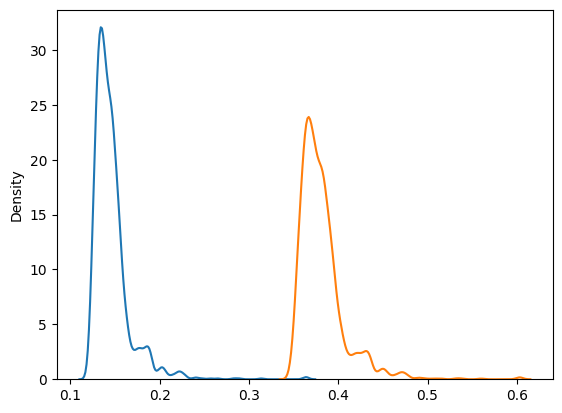

In [46]:
ii = 9
jj = 0
sns.kdeplot(usable[ii][jj])
sns.kdeplot((usable[ii][jj])**0.5)
skew(usable[ii][jj]) , skew((usable[ii][jj])**0.5) 

In [47]:
means = np.mean(usable,axis=(2))
means.shape

(4104, 13)

In [48]:
medians = np.median(usable,axis=(2))
medians.shape

(4104, 13)

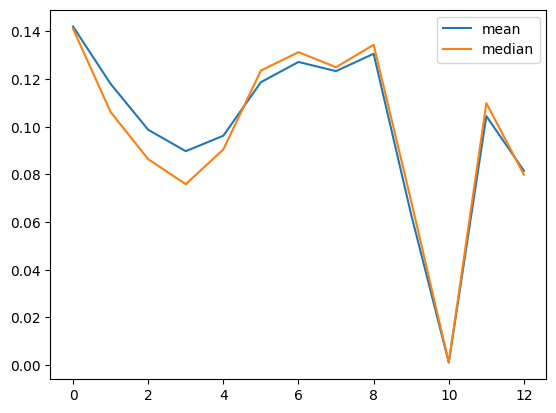

In [49]:
plt.plot(means[12],label='mean')
plt.plot(medians[12],label='median')
plt.legend()

In [50]:
new_usable = []
for idx , img in enumerate(usable):
    for band in range(usable.shape[1]):
        img[band][img[band] <= 0] = means[idx][band]
    new_usable.append(img)
new_usable = np.array(new_usable)


In [51]:
train_df = train_df.iloc[usable_idx]
len(train_df)

4104

In [52]:
train_df = train_df.reset_index().drop('index',axis=1)

In [53]:
train_df

,file,aod,path,loc_encoded
0,train_1.tif,0.041617,train_images/train_1.tif,0
1,train_3.tif,0.214568,train_images/train_3.tif,2
2,train_4.tif,0.084528,train_images/train_4.tif,3
3,train_5.tif,0.085251,train_images/train_5.tif,4
4,train_6.tif,0.130016,train_images/train_6.tif,5
...,...,...,...,...
4099,train_4460.tif,0.117341,train_images/train_4460.tif,34
4100,train_4461.tif,0.357386,train_images/train_4461.tif,8
4101,train_4463.tif,0.768371,train_images/train_4463.tif,31
4102,train_4464.tif,0.077829,train_images/train_4464.tif,53


In [54]:
usable.shape , bands.shape

((4104, 13, 16384), (4465, 13, 16384))

In [55]:
usable = new_usable**0.5

In [56]:
np.save('/home/modar/Compete/preprocessed_data/root_usable.npy',usable)
np.save('/home/modar/Compete/preprocessed_data/root_usable_idx.npy',usable_idx)

In [57]:
usable = np.load('/home/modar/Compete/preprocessed_data/root_usable.npy')
usable_idx = np.load('/home/modar/Compete/preprocessed_data/root_usable_idx.npy')
usable.shape , usable_idx.shape

((4104, 13, 16384), (4104,))

In [58]:
###train_df = rededge_indices(train_df, bands)
train_df = rededge_indices(train_df, usable)
train_df.to_csv('/home/modar/Compete/preprocessed_data/red_edge.csv')

100%|███████████████████████████████████████████| 18/18 [03:07<00:00, 10.43s/it]


In [59]:
train_df

,file,aod,path,loc_encoded,NDVIre1_mean,NDVIre1_var,NDVIre1_median,NDVIre1_kurtosis,NDVIre1_skew,NDVIre1_std,...,MTCI2_GLCM_Dissimilarity,MTCI2_GLCM_Homogeneity,MTCI2_GLCM_Contrast,MTCI2_GLCM_Correlation,MTCI2_GLCM_Energy,MTCI3_GLCM_Dissimilarity,MTCI3_GLCM_Homogeneity,MTCI3_GLCM_Contrast,MTCI3_GLCM_Correlation,MTCI3_GLCM_Energy
0,train_1.tif,0.041617,train_images/train_1.tif,0,0.135784,0.004715,0.129668,-0.236626,0.216283,0.068667,...,22.708538,0.559218,4759.982776,0.395890,0.296505,1.806656,0.949816,391.252153,0.079106,0.911918
1,train_3.tif,0.214568,train_images/train_3.tif,2,0.228243,0.005037,0.248978,0.268203,-1.004819,0.070972,...,11.793553,0.592704,2290.985359,0.184127,0.279865,0.195743,0.992029,39.852854,0.002129,0.986182
2,train_4.tif,0.084528,train_images/train_4.tif,3,0.019984,0.001787,0.018500,1.152258,0.447060,0.042273,...,63.958354,0.368430,15127.812315,0.072213,0.186447,43.529035,0.641714,10577.113435,0.105042,0.556386
3,train_5.tif,0.085251,train_images/train_5.tif,4,0.076172,0.001609,0.076495,-0.069323,0.177439,0.040118,...,55.359252,0.339929,12320.782726,0.119433,0.163412,7.627645,0.870200,1767.039801,0.079533,0.806642
4,train_6.tif,0.130016,train_images/train_6.tif,5,0.245261,0.009423,0.244353,-0.765161,-0.305058,0.097070,...,3.271654,0.736352,584.128199,0.700169,0.334917,0.993725,0.992040,243.344365,0.700918,0.987394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4099,train_4460.tif,0.117341,train_images/train_4460.tif,34,0.131673,0.000847,0.133433,3.370576,0.079525,0.029105,...,2.458292,0.754422,397.640994,0.325485,0.455148,0.100148,0.997512,23.247047,0.005421,0.995880
4100,train_4461.tif,0.357386,train_images/train_4461.tif,8,0.026131,0.000839,0.020621,0.124130,0.649845,0.028961,...,33.654712,0.459533,7574.586184,0.199233,0.230695,8.627522,0.877779,2048.325726,0.105722,0.823301
4101,train_4463.tif,0.768371,train_images/train_4463.tif,31,0.088086,0.001777,0.085117,-1.079115,0.038992,0.042154,...,10.086122,0.543683,1817.112082,0.180940,0.254747,0.109437,0.992360,21.424889,-0.000133,0.986616
4102,train_4464.tif,0.077829,train_images/train_4464.tif,53,0.020662,0.004001,0.016163,1.576034,0.688485,0.063252,...,100.351378,0.245691,23448.050443,0.126965,0.117419,50.065699,0.589322,12073.573696,0.149606,0.493212


In [60]:
train_df = pd.read_csv("/home/modar/Compete/preprocessed_data/red_edge.csv")
train_df = train_df.drop('Unnamed: 0',axis=1)
train_df

,file,aod,path,loc_encoded,NDVIre1_mean,NDVIre1_var,NDVIre1_median,NDVIre1_kurtosis,NDVIre1_skew,NDVIre1_std,...,MTCI2_GLCM_Dissimilarity,MTCI2_GLCM_Homogeneity,MTCI2_GLCM_Contrast,MTCI2_GLCM_Correlation,MTCI2_GLCM_Energy,MTCI3_GLCM_Dissimilarity,MTCI3_GLCM_Homogeneity,MTCI3_GLCM_Contrast,MTCI3_GLCM_Correlation,MTCI3_GLCM_Energy
0,train_1.tif,0.041617,train_images/train_1.tif,0,0.135784,0.004715,0.129668,-0.236626,0.216283,0.068667,...,22.708538,0.559218,4759.982776,0.395890,0.296505,1.806656,0.949816,391.252153,0.079106,0.911918
1,train_3.tif,0.214568,train_images/train_3.tif,2,0.228243,0.005037,0.248978,0.268203,-1.004819,0.070972,...,11.793553,0.592704,2290.985359,0.184127,0.279865,0.195743,0.992029,39.852854,0.002129,0.986182
2,train_4.tif,0.084528,train_images/train_4.tif,3,0.019984,0.001787,0.018500,1.152258,0.447060,0.042273,...,63.958354,0.368430,15127.812315,0.072213,0.186447,43.529035,0.641714,10577.113435,0.105042,0.556386
3,train_5.tif,0.085251,train_images/train_5.tif,4,0.076172,0.001609,0.076495,-0.069323,0.177439,0.040118,...,55.359252,0.339929,12320.782726,0.119433,0.163412,7.627645,0.870200,1767.039801,0.079533,0.806642
4,train_6.tif,0.130016,train_images/train_6.tif,5,0.245261,0.009423,0.244353,-0.765161,-0.305058,0.097070,...,3.271654,0.736352,584.128199,0.700169,0.334917,0.993725,0.992040,243.344365,0.700918,0.987394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4099,train_4460.tif,0.117341,train_images/train_4460.tif,34,0.131673,0.000847,0.133433,3.370576,0.079525,0.029105,...,2.458292,0.754422,397.640994,0.325485,0.455148,0.100148,0.997512,23.247047,0.005421,0.995880
4100,train_4461.tif,0.357386,train_images/train_4461.tif,8,0.026131,0.000839,0.020621,0.124130,0.649845,0.028961,...,33.654712,0.459533,7574.586184,0.199233,0.230695,8.627522,0.877779,2048.325726,0.105722,0.823301
4101,train_4463.tif,0.768371,train_images/train_4463.tif,31,0.088086,0.001777,0.085117,-1.079115,0.038992,0.042154,...,10.086122,0.543683,1817.112082,0.180940,0.254747,0.109437,0.992360,21.424889,-0.000133,0.986616
4102,train_4464.tif,0.077829,train_images/train_4464.tif,53,0.020662,0.004001,0.016163,1.576034,0.688485,0.063252,...,100.351378,0.245691,23448.050443,0.126965,0.117419,50.065699,0.589322,12073.573696,0.149606,0.493212


In [61]:
train_df = calculate_statistics(basic_bands,train_df,usable)
train_df.to_csv('/home/modar/Compete/preprocessed_data/stats.csv')

100%|███████████████████████████████████████████| 13/13 [00:51<00:00,  3.93s/it]
78it [05:39,  4.35s/it]
78it [05:25,  4.17s/it]


In [62]:
len(train_df)

4104

In [63]:
train_df = pd.read_csv("/home/modar/Compete/preprocessed_data/stats.csv")
train_df = train_df.drop('Unnamed: 0',axis=1)
train_df.head(5)

,file,aod,path,loc_encoded,NDVIre1_mean,NDVIre1_var,NDVIre1_median,NDVIre1_kurtosis,NDVIre1_skew,NDVIre1_std,...,band_11_12_mean,band_11_12_median,band_11_12_var,band_11_12_kurtosis,band_11_12_skew,band_11_12_std,band_11_12_10th_percentile,band_11_12_25th_percentile,band_11_12_75th_percentile,band_11_12_90th_percentile
0,train_1.tif,0.041617,train_images/train_1.tif,0,0.135784,0.004715,0.129668,-0.236626,0.216283,0.068667,...,1.194521,1.156907,0.018554,-0.610768,-0.156251,0.136211,1.144897,1.228150,1.398864,1.462407
1,train_3.tif,0.214568,train_images/train_3.tif,2,0.228243,0.005037,0.248978,0.268203,-1.004819,0.070972,...,1.194521,1.156907,0.018554,-0.274626,-0.505575,0.136211,1.206975,1.333916,1.575602,1.624216
2,train_4.tif,0.084528,train_images/train_4.tif,3,0.019984,0.001787,0.018500,1.152258,0.447060,0.042273,...,1.194521,1.156907,0.018554,4.121595,0.256200,0.136211,1.024066,1.048940,1.109823,1.147612
3,train_5.tif,0.085251,train_images/train_5.tif,4,0.076172,0.001609,0.076495,-0.069323,0.177439,0.040118,...,1.194521,1.156907,0.018554,-0.211165,0.444535,0.136211,1.130956,1.159732,1.261478,1.312357
4,train_6.tif,0.130016,train_images/train_6.tif,5,0.245261,0.009423,0.244353,-0.765161,-0.305058,0.097070,...,1.194521,1.156907,0.018554,-1.001685,-0.161402,0.136211,1.218663,1.327183,1.588064,1.658914


In [64]:
train_df = bloom_indices(train_df,usable)
train_df.to_csv('/home/modar/Compete/preprocessed_data/bloom.csv')

100%|█████████████████████████████████████████████| 6/6 [00:57<00:00,  9.65s/it]


In [65]:
train_df = pd.read_csv("/home/modar/Compete/preprocessed_data/bloom.csv")
train_df = train_df.drop('Unnamed: 0',axis=1)
train_df

,file,aod,path,loc_encoded,NDVIre1_mean,NDVIre1_var,NDVIre1_median,NDVIre1_kurtosis,NDVIre1_skew,NDVIre1_std,...,NDYI_GLCM_Dissimilarity,NDYI_GLCM_Homogeneity,NDYI_GLCM_Contrast,NDYI_GLCM_Correlation,NDYI_GLCM_Energy,YEBI_GLCM_Dissimilarity,YEBI_GLCM_Homogeneity,YEBI_GLCM_Contrast,YEBI_GLCM_Correlation,YEBI_GLCM_Energy
0,train_1.tif,0.041617,train_images/train_1.tif,0,0.135784,0.004715,0.129668,-0.236626,0.216283,0.068667,...,0.0,1.0,0.0,1.0,1.0,0.000000,1.000000,0.00000,1.000000,1.000000
1,train_3.tif,0.214568,train_images/train_3.tif,2,0.228243,0.005037,0.248978,0.268203,-1.004819,0.070972,...,0.0,1.0,0.0,1.0,1.0,0.000000,1.000000,0.00000,1.000000,1.000000
2,train_4.tif,0.084528,train_images/train_4.tif,3,0.019984,0.001787,0.018500,1.152258,0.447060,0.042273,...,0.0,1.0,0.0,1.0,1.0,0.000000,1.000000,0.00000,1.000000,1.000000
3,train_5.tif,0.085251,train_images/train_5.tif,4,0.076172,0.001609,0.076495,-0.069323,0.177439,0.040118,...,0.0,1.0,0.0,1.0,1.0,0.000000,1.000000,0.00000,1.000000,1.000000
4,train_6.tif,0.130016,train_images/train_6.tif,5,0.245261,0.009423,0.244353,-0.765161,-0.305058,0.097070,...,0.0,1.0,0.0,1.0,1.0,0.000000,1.000000,0.00000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4099,train_4460.tif,0.117341,train_images/train_4460.tif,34,0.131673,0.000847,0.133433,3.370576,0.079525,0.029105,...,0.0,1.0,0.0,1.0,1.0,0.000000,1.000000,0.00000,1.000000,1.000000
4100,train_4461.tif,0.357386,train_images/train_4461.tif,8,0.026131,0.000839,0.020621,0.124130,0.649845,0.028961,...,0.0,1.0,0.0,1.0,1.0,0.000000,1.000000,0.00000,1.000000,1.000000
4101,train_4463.tif,0.768371,train_images/train_4463.tif,31,0.088086,0.001777,0.085117,-1.079115,0.038992,0.042154,...,0.0,1.0,0.0,1.0,1.0,0.000000,1.000000,0.00000,1.000000,1.000000
4102,train_4464.tif,0.077829,train_images/train_4464.tif,53,0.020662,0.004001,0.016163,1.576034,0.688485,0.063252,...,0.0,1.0,0.0,1.0,1.0,2.996125,0.988251,764.01175,0.839237,0.956714


In [66]:
train_df = compute_texture_features(basic_bands,train_df,usable)
train_df.to_csv('/home/modar/Compete/preprocessed_data/texture.csv')

Aerosols_GLCM_Dissimilarity
Blue_GLCM_Dissimilarity
Green_GLCM_Dissimilarity
Red_GLCM_Dissimilarity
Red_edge_1_GLCM_Dissimilarity
Red_edge_2_GLCM_Dissimilarity
Red_edge_3_GLCM_Dissimilarity
NIR_GLCM_Dissimilarity
 Red_edge_4_GLCM_Dissimilarity
Water_vapor_GLCM_Dissimilarity
SWIR1_GLCM_Dissimilarity
SWIR2__GLCM_Dissimilarity
Aerosol_Optical_Thickness_GLCM_Dissimilarity


In [67]:
train_df = pd.read_csv("/home/modar/Compete/preprocessed_data/texture.csv")
train_df = train_df.drop('Unnamed: 0',axis=1)
train_df

,file,aod,path,loc_encoded,NDVIre1_mean,NDVIre1_var,NDVIre1_median,NDVIre1_kurtosis,NDVIre1_skew,NDVIre1_std,...,SWIR2__energy,SWIR2__homogeneity,SWIR2__GLCM_Dissimilarity,SWIR2__Homogeneity,Aerosol_Optical_Thickness_contrast,Aerosol_Optical_Thickness_correlation,Aerosol_Optical_Thickness_energy,Aerosol_Optical_Thickness_homogeneity,Aerosol_Optical_Thickness_GLCM_Dissimilarity,Aerosol_Optical_Thickness_Homogeneity
0,train_1.tif,0.041617,train_images/train_1.tif,0,0.135784,0.004715,0.129668,-0.236626,0.216283,0.068667,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
1,train_3.tif,0.214568,train_images/train_3.tif,2,0.228243,0.005037,0.248978,0.268203,-1.004819,0.070972,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
2,train_4.tif,0.084528,train_images/train_4.tif,3,0.019984,0.001787,0.018500,1.152258,0.447060,0.042273,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
3,train_5.tif,0.085251,train_images/train_5.tif,4,0.076172,0.001609,0.076495,-0.069323,0.177439,0.040118,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
4,train_6.tif,0.130016,train_images/train_6.tif,5,0.245261,0.009423,0.244353,-0.765161,-0.305058,0.097070,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4099,train_4460.tif,0.117341,train_images/train_4460.tif,34,0.131673,0.000847,0.133433,3.370576,0.079525,0.029105,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
4100,train_4461.tif,0.357386,train_images/train_4461.tif,8,0.026131,0.000839,0.020621,0.124130,0.649845,0.028961,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
4101,train_4463.tif,0.768371,train_images/train_4463.tif,31,0.088086,0.001777,0.085117,-1.079115,0.038992,0.042154,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
4102,train_4464.tif,0.077829,train_images/train_4464.tif,53,0.020662,0.004001,0.016163,1.576034,0.688485,0.063252,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0


In [39]:
train_df = calculate_vegetation_indices(train_df,usable)
train_df.to_csv('/home/modar/Compete/preprocessed_data/vegetation.csv')
train_df.head(5) 

100%|███████████████████████████████████████████| 20/20 [03:11<00:00,  9.57s/it]


,file,location,aod,path,NDVIre1_mean,NDVIre1_var,NDVIre1_median,NDVIre1_kurtosis,NDVIre1_skew,NDVIre1_std,...,savi_GLCM_Dissimilarity,savi_GLCM_Homogeneity,savi_GLCM_Contrast,savi_GLCM_Correlation,savi_GLCM_Energy,bsi_GLCM_Dissimilarity,bsi_GLCM_Homogeneity,bsi_GLCM_Contrast,bsi_GLCM_Correlation,bsi_GLCM_Energy
0,train_1.tif,Camaguey,0.041617,train_images/train_1.tif,0.135784,0.004715,0.129668,-0.236626,0.216283,0.068667,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
1,train_3.tif,Hong_Kong_Sheung,0.214568,train_images/train_3.tif,0.228243,0.005037,0.248978,0.268203,-1.004819,0.070972,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
2,train_4.tif,Beijing-CAMS,0.084528,train_images/train_4.tif,0.019984,0.001787,0.018500,1.152258,0.447060,0.042273,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
3,train_5.tif,ATHENS_NTUA,0.085251,train_images/train_5.tif,0.076172,0.001609,0.076495,-0.069323,0.177439,0.040118,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
4,train_6.tif,Kellogg_LTER,0.130016,train_images/train_6.tif,0.245261,0.009423,0.244353,-0.765161,-0.305058,0.097070,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0


In [40]:
train_df = pd.read_csv("/home/modar/Compete/preprocessed_data/vegetation.csv")
train_df = train_df.drop('Unnamed: 0',axis=1)
train_df.head(5)

,file,location,aod,path,NDVIre1_mean,NDVIre1_var,NDVIre1_median,NDVIre1_kurtosis,NDVIre1_skew,NDVIre1_std,...,savi_GLCM_Dissimilarity,savi_GLCM_Homogeneity,savi_GLCM_Contrast,savi_GLCM_Correlation,savi_GLCM_Energy,bsi_GLCM_Dissimilarity,bsi_GLCM_Homogeneity,bsi_GLCM_Contrast,bsi_GLCM_Correlation,bsi_GLCM_Energy
0,train_1.tif,Camaguey,0.041617,train_images/train_1.tif,0.135784,0.004715,0.129668,-0.236626,0.216283,0.068667,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
1,train_3.tif,Hong_Kong_Sheung,0.214568,train_images/train_3.tif,0.228243,0.005037,0.248978,0.268203,-1.004819,0.070972,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
2,train_4.tif,Beijing-CAMS,0.084528,train_images/train_4.tif,0.019984,0.001787,0.018500,1.152258,0.447060,0.042273,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
3,train_5.tif,ATHENS_NTUA,0.085251,train_images/train_5.tif,0.076172,0.001609,0.076495,-0.069323,0.177439,0.040118,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
4,train_6.tif,Kellogg_LTER,0.130016,train_images/train_6.tif,0.245261,0.009423,0.244353,-0.765161,-0.305058,0.097070,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0


In [41]:
train_df = calculate_vegetation_indices2(train_df,usable)
train_df.to_csv('/home/modar/Compete/preprocessed_data/vegetation2.csv')

 52%|██████████████████████▎                    | 13/25 [02:03<01:52,  9.41s/it]/tmp/ipykernel_13180/3225085219.py:371: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  new_cols[str(vegetation_band_name) + '_kurtosis'] = kurtosis(vegetation_band_vals,axis=1)
/tmp/ipykernel_13180/3225085219.py:372: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  new_cols[str(vegetation_band_name) + '_skew'] = skew(vegetation_band_vals,axis=1)
100%|███████████████████████████████████████████| 25/25 [03:58<00:00,  9.53s/it]


In [42]:
train_df = pd.read_csv("/home/modar/Compete/preprocessed_data/vegetation2.csv")
train_df = train_df.drop('Unnamed: 0',axis=1)
train_df.head(5)

,file,location,aod,path,NDVIre1_mean,NDVIre1_var,NDVIre1_median,NDVIre1_kurtosis,NDVIre1_skew,NDVIre1_std,...,exg_GLCM_Dissimilarity,exg_GLCM_Homogeneity,exg_GLCM_Contrast,exg_GLCM_Correlation,exg_GLCM_Energy,aci_GLCM_Dissimilarity,aci_GLCM_Homogeneity,aci_GLCM_Contrast,aci_GLCM_Correlation,aci_GLCM_Energy
0,train_1.tif,Camaguey,0.041617,train_images/train_1.tif,0.135784,0.004715,0.129668,-0.236626,0.216283,0.068667,...,0.0,1.0,0.0,1.0,1.0,0.000123,0.999938,0.000123,-0.000062,0.999877
1,train_3.tif,Hong_Kong_Sheung,0.214568,train_images/train_3.tif,0.228243,0.005037,0.248978,0.268203,-1.004819,0.070972,...,0.0,1.0,0.0,1.0,1.0,0.000123,0.999938,0.000123,-0.000062,0.999877
2,train_4.tif,Beijing-CAMS,0.084528,train_images/train_4.tif,0.019984,0.001787,0.018500,1.152258,0.447060,0.042273,...,0.0,1.0,0.0,1.0,1.0,0.000738,0.999631,0.000738,0.599631,0.998708
3,train_5.tif,ATHENS_NTUA,0.085251,train_images/train_5.tif,0.076172,0.001609,0.076495,-0.069323,0.177439,0.040118,...,0.0,1.0,0.0,1.0,1.0,0.000000,1.000000,0.000000,1.000000,1.000000
4,train_6.tif,Kellogg_LTER,0.130016,train_images/train_6.tif,0.245261,0.009423,0.244353,-0.765161,-0.305058,0.097070,...,0.0,1.0,0.0,1.0,1.0,0.000000,1.000000,0.000000,1.000000,1.000000


In [43]:
train_df = calculate_advanced_band_features(basic_bands,train_df,usable)
train_df.to_csv('/home/modar/Compete/preprocessed_data/stats_heavy.csv')

78it [00:46,  1.67it/s]
13it [00:22,  1.71s/it]
286it [00:42,  6.78it/s]
286it [00:39,  7.25it/s]


In [77]:
train_df = pd.read_csv("/home/modar/Compete/preprocessed_data/stats_heavy.csv")
train_df = train_df.drop('Unnamed: 0',axis=1)
train_df.head(5)

,blue_p50,green_p50,nir_p50,nira_p50,re1_p50,re2_p50,re3_p50,red_p50,swir1_p50,swir2_p50,...,band_7_8_9_custom_ratio,band_7_8_10_custom_ratio,band_7_8_11_custom_ratio,band_7_9_10_custom_ratio,band_7_9_11_custom_ratio,band_7_10_11_custom_ratio,band_8_9_10_custom_ratio,band_8_9_11_custom_ratio,band_8_10_11_custom_ratio,band_9_10_11_custom_ratio
0,1772.5,2081.5,4393.0,4322.0,2542.0,3974.5,4315.0,1901.5,2929.5,2324.0,...,2396.920934,-1.011596e+06,-336033.101769,-8.025089e+05,-266578.231272,631.642207,-1.236366e+06,-410697.306605,973.124294,771.988688
1,2178.0,2347.0,3427.0,3712.0,2658.5,3358.0,3628.5,2313.0,3122.0,2729.5,...,2645.607620,-9.259581e+05,-515531.255197,-8.095460e+05,-450718.309116,1287.772967,-1.092695e+06,-608362.542612,1738.187290,1519.661181
2,2927.0,3107.0,4365.0,4624.5,3378.0,4221.5,4508.5,3082.0,3921.0,3190.0,...,3788.251411,-1.579136e+06,-843892.674453,-1.284735e+06,-686564.047820,1647.025290,-1.634473e+06,-873464.513791,2095.388112,1704.740647
3,2175.0,2312.0,3472.5,3613.5,2569.5,3332.0,3558.5,2244.0,3132.5,2610.0,...,2693.229885,-7.375422e+05,-426745.493228,-6.145204e+05,-355564.481189,1298.389341,-8.578365e+05,-496348.367792,1812.479773,1510.158725
4,2125.0,2235.0,2612.0,2960.0,2548.5,2801.0,2908.0,2320.0,2915.0,2685.5,...,2518.264755,-6.948227e+05,-373508.531323,-6.401189e+05,-344101.941978,1247.137939,-8.042873e+05,-432352.224512,1566.985815,1443.615920


Original data stats: 0.04272634123661699 , 0.5751099333293433 , 0.9869957806682743
Squared data stats: -0.5188214401586538 , 0.7583600288315197 , 0.9366009016114211


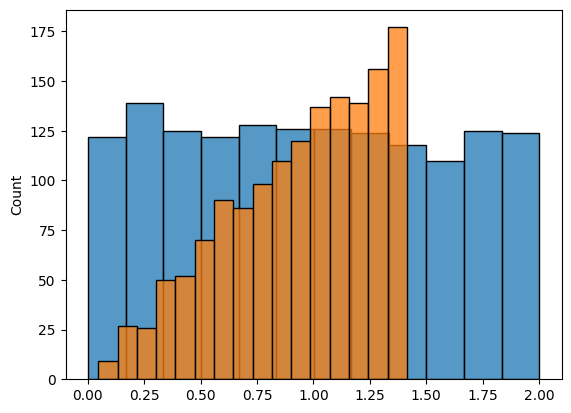

In [81]:
""""
Comparing the target variable distribution before & after applying square root.
"""
from sklearn.preprocessing import PowerTransformer

sns.histplot(aod)
sns.histplot(aod ** 0.5)


print(f'Original data stats: {skew(aod)} , {np.std(aod)} , {np.mean(aod)}')
print(f'Squared data stats: {skew(aod**0.5)} , {np.std(aod)**0.5} , {np.mean(aod**0.5)}')

In [83]:
np.max(aod - (aod**0.5)**2)

2.220446049250313e-16

In [88]:
threshold = 0.2 * len(train_df_scaling)
train_df_scaling.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df_scaling = train_df_scaling.dropna(thresh=threshold, axis=1)
train_df_scaling

,loc_encoded,NDVIre1_mean,NDVIre1_var,NDVIre1_median,NDVIre1_kurtosis,NDVIre1_skew,NDVIre1_std,NDVIre1_p10,NDVIre1_p25,NDVIre1_p75,...,SWIR2__energy,SWIR2__homogeneity,SWIR2__GLCM_Dissimilarity,SWIR2__Homogeneity,Aerosol_Optical_Thickness_contrast,Aerosol_Optical_Thickness_correlation,Aerosol_Optical_Thickness_energy,Aerosol_Optical_Thickness_homogeneity,Aerosol_Optical_Thickness_GLCM_Dissimilarity,Aerosol_Optical_Thickness_Homogeneity
0,0,0.135784,0.004715,0.129668,-0.236626,0.216283,0.068667,0.042638,0.092669,0.181568,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
1,2,0.228243,0.005037,0.248978,0.268203,-1.004819,0.070972,0.113641,0.192142,0.279855,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
2,3,0.019984,0.001787,0.018500,1.152258,0.447060,0.042273,-0.031281,-0.006605,0.044171,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
3,4,0.076172,0.001609,0.076495,-0.069323,0.177439,0.040118,0.023596,0.045785,0.105512,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
4,5,0.245261,0.009423,0.244353,-0.765161,-0.305058,0.097070,0.111112,0.173735,0.331184,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4099,34,0.131673,0.000847,0.133433,3.370576,0.079525,0.029105,0.098030,0.114279,0.149653,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
4100,8,0.026131,0.000839,0.020621,0.124130,0.649845,0.028961,-0.006069,0.004898,0.044052,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
4101,31,0.088086,0.001777,0.085117,-1.079115,0.038992,0.042154,0.033661,0.053631,0.125363,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
4102,53,0.020662,0.004001,0.016163,1.576034,0.688485,0.063252,-0.061186,-0.010569,0.047094,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0


In [89]:
np.save("/home/modar/Compete/preprocessed_data/train_features_root_before_processing.npy", train_df_scaling)

In [90]:
train_df_scaling.columns[train_df_scaling.isna().sum() > 0]

Index([], dtype='object')

In [92]:
###################### Imputing is done here ########################

######## using mean
for col in tqdm(train_df_scaling.columns.values):
    
    col_vals = train_df_scaling[col].replace([np.inf, -np.inf], np.nan)

    col_mean = np.nanmean(col_vals)

    train_df_scaling[col].replace([np.inf, -np.inf, np.nan], col_mean, inplace=True)


############ using KNN
"""
knn_imputer = KNNImputer(n_neighbors=5)

train_df_scaling = pd.DataFrame(knn_imputer.fit_transform(train_df_scaling), columns=train_df_scaling.columns)
"""

100%|█████████████████████████████████████| 1349/1349 [00:00<00:00, 2915.74it/s]


'\nknn_imputer = KNNImputer(n_neighbors=5)\n\ntrain_df_scaling = pd.DataFrame(knn_imputer.fit_transform(train_df_scaling), columns=train_df_scaling.columns)\n'

In [93]:
train_df_scaling_root = train_df_scaling

In [94]:
train_df_scaling['CIre1_kurtosis']

0       0.379848
1      -0.306332
2       2.368674
3       0.537760
4      -1.061950
          ...   
4099    5.505731
4100    0.443954
4101   -1.075934
4102    3.560993
4103    1.487220
Name: CIre1_kurtosis, Length: 4104, dtype: float64

In [95]:
train_df_scaling_root.head(3)

,loc_encoded,NDVIre1_mean,NDVIre1_var,NDVIre1_median,NDVIre1_kurtosis,NDVIre1_skew,NDVIre1_std,NDVIre1_p10,NDVIre1_p25,NDVIre1_p75,...,SWIR2__energy,SWIR2__homogeneity,SWIR2__GLCM_Dissimilarity,SWIR2__Homogeneity,Aerosol_Optical_Thickness_contrast,Aerosol_Optical_Thickness_correlation,Aerosol_Optical_Thickness_energy,Aerosol_Optical_Thickness_homogeneity,Aerosol_Optical_Thickness_GLCM_Dissimilarity,Aerosol_Optical_Thickness_Homogeneity
0,0,0.135784,0.004715,0.129668,-0.236626,0.216283,0.068667,0.042638,0.092669,0.181568,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
1,2,0.228243,0.005037,0.248978,0.268203,-1.004819,0.070972,0.113641,0.192142,0.279855,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
2,3,0.019984,0.001787,0.018500,1.152258,0.447060,0.042273,-0.031281,-0.006605,0.044171,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0


In [96]:
train_df_scaling.head(3)

,loc_encoded,NDVIre1_mean,NDVIre1_var,NDVIre1_median,NDVIre1_kurtosis,NDVIre1_skew,NDVIre1_std,NDVIre1_p10,NDVIre1_p25,NDVIre1_p75,...,SWIR2__energy,SWIR2__homogeneity,SWIR2__GLCM_Dissimilarity,SWIR2__Homogeneity,Aerosol_Optical_Thickness_contrast,Aerosol_Optical_Thickness_correlation,Aerosol_Optical_Thickness_energy,Aerosol_Optical_Thickness_homogeneity,Aerosol_Optical_Thickness_GLCM_Dissimilarity,Aerosol_Optical_Thickness_Homogeneity
0,0,0.135784,0.004715,0.129668,-0.236626,0.216283,0.068667,0.042638,0.092669,0.181568,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
1,2,0.228243,0.005037,0.248978,0.268203,-1.004819,0.070972,0.113641,0.192142,0.279855,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
2,3,0.019984,0.001787,0.018500,1.152258,0.447060,0.042273,-0.031281,-0.006605,0.044171,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0


In [97]:

#scaler = StandardScaler()
#train_df_scaled = scaler.fit_transform(train_df_scaling)
# Convert back to a DataFrame for easier handling
#train_df_scaling = pd.DataFrame(train_df_scaled, columns=train_df_scaling.columns)
#train_df_scaling.head(5)

scaler = QuantileTransformer(output_distribution='normal')
train_df_scaling = pd.DataFrame(scaler.fit_transform(train_df_scaling_root), columns=train_df_scaling_root.columns)
train_df_scaling.head(10)

,loc_encoded,NDVIre1_mean,NDVIre1_var,NDVIre1_median,NDVIre1_kurtosis,NDVIre1_skew,NDVIre1_std,NDVIre1_p10,NDVIre1_p25,NDVIre1_p75,...,SWIR2__energy,SWIR2__homogeneity,SWIR2__GLCM_Dissimilarity,SWIR2__Homogeneity,Aerosol_Optical_Thickness_contrast,Aerosol_Optical_Thickness_correlation,Aerosol_Optical_Thickness_energy,Aerosol_Optical_Thickness_homogeneity,Aerosol_Optical_Thickness_GLCM_Dissimilarity,Aerosol_Optical_Thickness_Homogeneity
0,-5.199338,1.023950,0.365603,1.016850,-0.422767,-0.422290,0.365603,0.910665,1.139815,0.915131,...,5.199338,5.199338,-5.199338,5.199338,-5.199338,5.199338,5.199338,5.199338,-5.199338,5.199338
1,-2.273052,1.910598,0.452782,1.942888,-0.031722,-1.931296,0.452782,1.898600,1.997343,1.751072,...,5.199338,5.199338,-5.199338,5.199338,-5.199338,5.199338,5.199338,5.199338,-5.199338,5.199338
2,-1.705570,-1.215371,-0.612769,-1.048413,0.418247,0.001752,-0.612768,-1.051561,-1.131929,-0.981813,...,5.199338,5.199338,-5.199338,5.199338,-5.199338,5.199338,5.199338,5.199338,-5.199338,5.199338
3,-1.407905,0.155208,-0.718322,0.259790,-0.292084,-0.493444,-0.718321,0.500646,0.367317,0.007966,...,5.199338,5.199338,-5.199338,5.199338,-5.199338,5.199338,5.199338,5.199338,-5.199338,5.199338
4,-1.337127,2.011021,1.315390,1.910588,-1.137466,-1.189547,1.315390,1.879464,1.913445,2.369187,...,5.199338,5.199338,-5.199338,5.199338,-5.199338,5.199338,5.199338,5.199338,-5.199338,5.199338
5,-1.233962,-1.275298,2.285200,-0.059046,-2.874647,-0.732010,2.285210,-1.926090,-2.510026,0.238407,...,5.199338,5.199338,-5.199338,5.199338,-5.199338,5.199338,5.199338,5.199338,-5.199338,5.199338
6,-1.055293,-0.354380,-0.727258,-0.447309,0.911327,1.021776,-0.727258,-0.094839,-0.228044,-0.558391,...,5.199338,5.199338,-5.199338,5.199338,1.081940,-1.669112,-1.059682,-1.081940,1.081940,-1.081940
7,-0.879040,-0.828950,-1.042382,-0.860902,1.106728,0.502410,-1.042381,-0.673280,-0.773139,-0.953687,...,-1.161976,-1.179402,1.179402,-1.179402,1.324958,-1.144896,-1.442543,-1.428482,1.324958,-1.428482
8,-0.812654,1.092528,1.074292,0.985062,-1.073234,0.060274,1.074292,0.830202,0.870662,1.125466,...,-1.471555,-1.602210,1.644369,-1.602210,1.710968,-0.997920,-1.851734,-1.710968,1.710968,-1.710968
9,-0.795322,1.184485,0.387713,1.258194,-0.741351,-1.179179,0.387713,1.033993,1.235716,1.093104,...,-2.196902,-2.144011,2.183092,-2.144011,2.307607,-1.226054,-2.212661,-2.307607,2.307607,-2.307607


<Axes: >

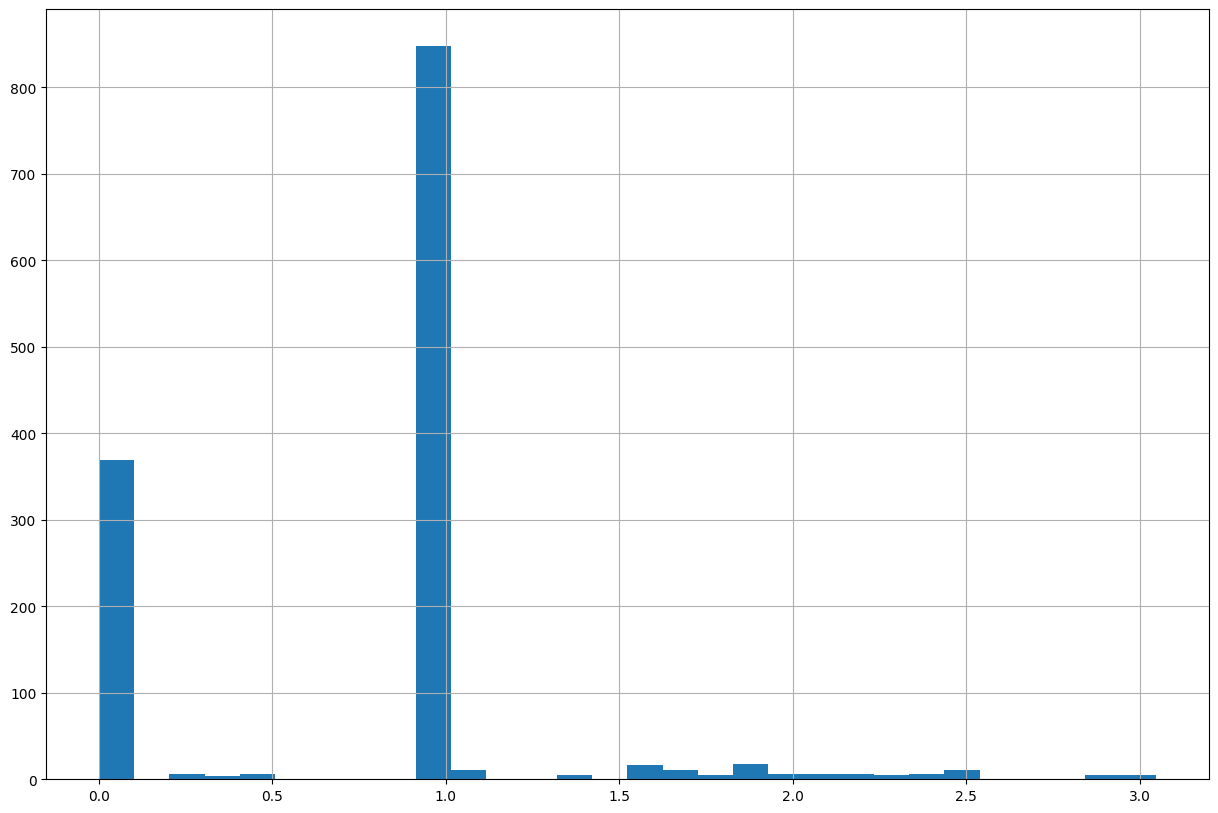

In [98]:
std = np.std(train_df_scaling)
std.hist(bins=30, figsize=(15, 10))

In [99]:
train_df_scaling = train_df_scaling.loc[:,train_df_scaling.std() > 1e-5]
std = np.std(train_df_scaling)
train_df_scaling

,loc_encoded,NDVIre1_mean,NDVIre1_var,NDVIre1_median,NDVIre1_kurtosis,NDVIre1_skew,NDVIre1_std,NDVIre1_p10,NDVIre1_p25,NDVIre1_p75,...,SWIR2__energy,SWIR2__homogeneity,SWIR2__GLCM_Dissimilarity,SWIR2__Homogeneity,Aerosol_Optical_Thickness_contrast,Aerosol_Optical_Thickness_correlation,Aerosol_Optical_Thickness_energy,Aerosol_Optical_Thickness_homogeneity,Aerosol_Optical_Thickness_GLCM_Dissimilarity,Aerosol_Optical_Thickness_Homogeneity
0,-5.199338,1.023950,0.365603,1.016850,-0.422767,-0.422290,0.365603,0.910665,1.139815,0.915131,...,5.199338,5.199338,-5.199338,5.199338,-5.199338,5.199338,5.199338,5.199338,-5.199338,5.199338
1,-2.273052,1.910598,0.452782,1.942888,-0.031722,-1.931296,0.452782,1.898600,1.997343,1.751072,...,5.199338,5.199338,-5.199338,5.199338,-5.199338,5.199338,5.199338,5.199338,-5.199338,5.199338
2,-1.705570,-1.215371,-0.612769,-1.048413,0.418247,0.001752,-0.612768,-1.051561,-1.131929,-0.981813,...,5.199338,5.199338,-5.199338,5.199338,-5.199338,5.199338,5.199338,5.199338,-5.199338,5.199338
3,-1.407905,0.155208,-0.718322,0.259790,-0.292084,-0.493444,-0.718321,0.500646,0.367317,0.007966,...,5.199338,5.199338,-5.199338,5.199338,-5.199338,5.199338,5.199338,5.199338,-5.199338,5.199338
4,-1.337127,2.011021,1.315390,1.910588,-1.137466,-1.189547,1.315390,1.879464,1.913445,2.369187,...,5.199338,5.199338,-5.199338,5.199338,-5.199338,5.199338,5.199338,5.199338,-5.199338,5.199338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4099,0.365531,0.981184,-1.283130,1.053546,0.953772,-0.659350,-1.283129,1.758805,1.386099,0.513917,...,5.199338,5.199338,-5.199338,5.199338,-5.199338,5.199338,5.199338,5.199338,-5.199338,5.199338
4100,-0.879040,-0.851405,-1.292768,-0.954430,-0.128521,0.253511,-1.292767,-0.563620,-0.777653,-0.985313,...,5.199338,5.199338,-5.199338,5.199338,-5.199338,5.199338,5.199338,5.199338,-5.199338,5.199338
4101,0.231641,0.285051,-0.620647,0.368560,-1.788105,-0.737031,-0.620647,0.757330,0.590809,0.249293,...,5.199338,5.199338,-5.199338,5.199338,-5.199338,5.199338,5.199338,5.199338,-5.199338,5.199338
4102,1.016672,-1.158571,0.173230,-1.275062,0.559563,0.290084,0.173230,-1.352404,-1.230381,-0.923444,...,5.199338,5.199338,-5.199338,5.199338,-5.199338,5.199338,5.199338,5.199338,-5.199338,5.199338


<Axes: >

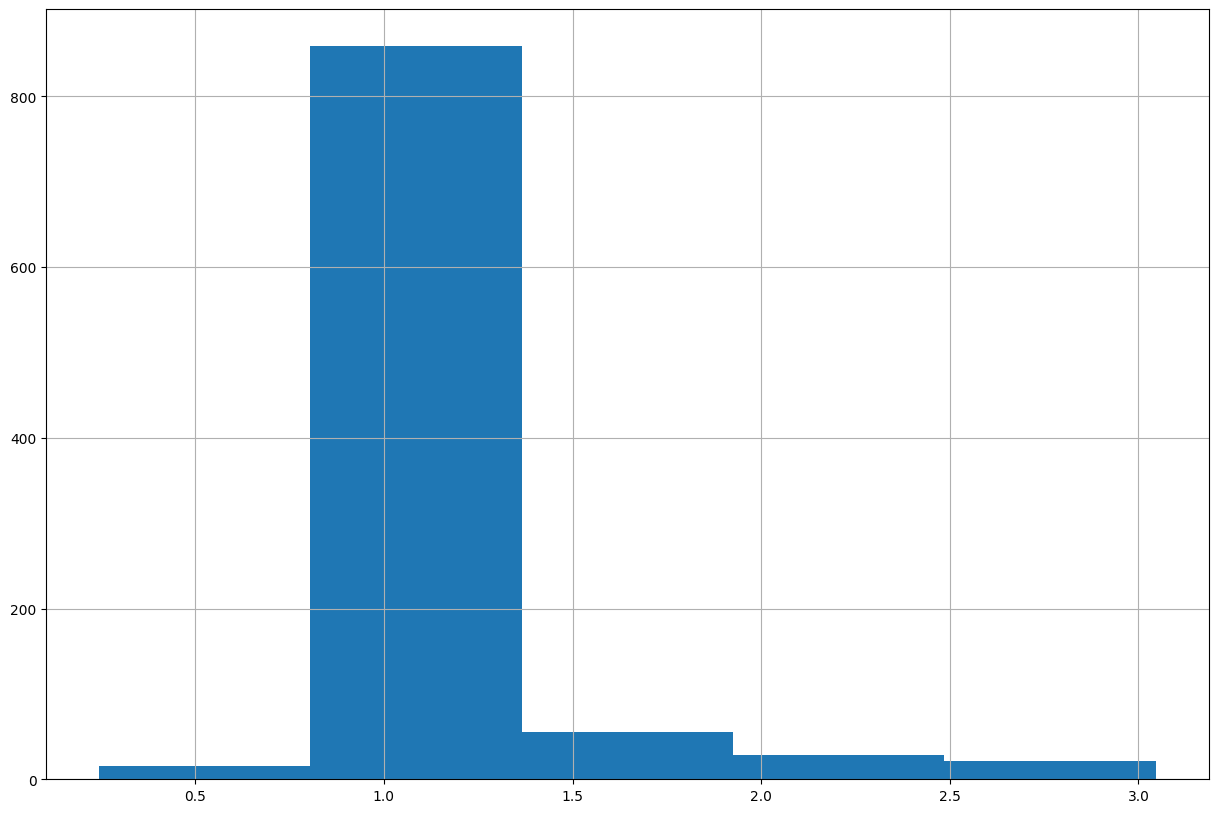

In [100]:
std.hist(bins=5, figsize=(15, 10))

In [102]:
train_df_normalized = train_df_scaling#.drop('index',axis=1)
train_df_normalized

,loc_encoded,NDVIre1_mean,NDVIre1_var,NDVIre1_median,NDVIre1_kurtosis,NDVIre1_skew,NDVIre1_std,NDVIre1_p10,NDVIre1_p25,NDVIre1_p75,...,SWIR2__energy,SWIR2__homogeneity,SWIR2__GLCM_Dissimilarity,SWIR2__Homogeneity,Aerosol_Optical_Thickness_contrast,Aerosol_Optical_Thickness_correlation,Aerosol_Optical_Thickness_energy,Aerosol_Optical_Thickness_homogeneity,Aerosol_Optical_Thickness_GLCM_Dissimilarity,Aerosol_Optical_Thickness_Homogeneity
0,-5.199338,1.023950,0.365603,1.016850,-0.422767,-0.422290,0.365603,0.910665,1.139815,0.915131,...,5.199338,5.199338,-5.199338,5.199338,-5.199338,5.199338,5.199338,5.199338,-5.199338,5.199338
1,-2.273052,1.910598,0.452782,1.942888,-0.031722,-1.931296,0.452782,1.898600,1.997343,1.751072,...,5.199338,5.199338,-5.199338,5.199338,-5.199338,5.199338,5.199338,5.199338,-5.199338,5.199338
2,-1.705570,-1.215371,-0.612769,-1.048413,0.418247,0.001752,-0.612768,-1.051561,-1.131929,-0.981813,...,5.199338,5.199338,-5.199338,5.199338,-5.199338,5.199338,5.199338,5.199338,-5.199338,5.199338
3,-1.407905,0.155208,-0.718322,0.259790,-0.292084,-0.493444,-0.718321,0.500646,0.367317,0.007966,...,5.199338,5.199338,-5.199338,5.199338,-5.199338,5.199338,5.199338,5.199338,-5.199338,5.199338
4,-1.337127,2.011021,1.315390,1.910588,-1.137466,-1.189547,1.315390,1.879464,1.913445,2.369187,...,5.199338,5.199338,-5.199338,5.199338,-5.199338,5.199338,5.199338,5.199338,-5.199338,5.199338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4099,0.365531,0.981184,-1.283130,1.053546,0.953772,-0.659350,-1.283129,1.758805,1.386099,0.513917,...,5.199338,5.199338,-5.199338,5.199338,-5.199338,5.199338,5.199338,5.199338,-5.199338,5.199338
4100,-0.879040,-0.851405,-1.292768,-0.954430,-0.128521,0.253511,-1.292767,-0.563620,-0.777653,-0.985313,...,5.199338,5.199338,-5.199338,5.199338,-5.199338,5.199338,5.199338,5.199338,-5.199338,5.199338
4101,0.231641,0.285051,-0.620647,0.368560,-1.788105,-0.737031,-0.620647,0.757330,0.590809,0.249293,...,5.199338,5.199338,-5.199338,5.199338,-5.199338,5.199338,5.199338,5.199338,-5.199338,5.199338
4102,1.016672,-1.158571,0.173230,-1.275062,0.559563,0.290084,0.173230,-1.352404,-1.230381,-0.923444,...,5.199338,5.199338,-5.199338,5.199338,-5.199338,5.199338,5.199338,5.199338,-5.199338,5.199338


In [105]:
targets = aod
features = train_df_normalized
#features = (features - features.min() ) / (features.max() - features.min())
#scaler = MinMaxScaler()
#features = scaler.fit_transform(features)
targets[:5] , features.head(5) 

(array([1.44246981, 0.91037409, 0.50074501, 0.99988238, 1.66820557]),
    loc_encoded  NDVIre1_mean  NDVIre1_var  NDVIre1_median  NDVIre1_kurtosis  \
 0    -5.199338      1.023950     0.365603        1.016850         -0.422767   
 1    -2.273052      1.910598     0.452782        1.942888         -0.031722   
 2    -1.705570     -1.215371    -0.612769       -1.048413          0.418247   
 3    -1.407905      0.155208    -0.718322        0.259790         -0.292084   
 4    -1.337127      2.011021     1.315390        1.910588         -1.137466   
 
    NDVIre1_skew  NDVIre1_std  NDVIre1_p10  NDVIre1_p25  NDVIre1_p75  ...  \
 0     -0.422290     0.365603     0.910665     1.139815     0.915131  ...   
 1     -1.931296     0.452782     1.898600     1.997343     1.751072  ...   
 2      0.001752    -0.612768    -1.051561    -1.131929    -0.981813  ...   
 3     -0.493444    -0.718321     0.500646     0.367317     0.007966  ...   
 4     -1.189547     1.315390     1.879464     1.913445     2.3

In [106]:
targets = np.array(targets)
features = np.array(features)
targets.shape , features.shape 

((1489,), (4104, 980))

In [107]:
features[:5]

array([[-5.19933758,  1.02395005,  0.3656034 , ...,  5.19933758,
        -5.19933758,  5.19933758],
       [-2.27305239,  1.91059811,  0.45278238, ...,  5.19933758,
        -5.19933758,  5.19933758],
       [-1.70557043, -1.21537129, -0.61276892, ...,  5.19933758,
        -5.19933758,  5.19933758],
       [-1.40790515,  0.15520795, -0.71832154, ...,  5.19933758,
        -5.19933758,  5.19933758],
       [-1.33712701,  2.0110206 ,  1.31538998, ...,  5.19933758,
        -5.19933758,  5.19933758]])

In [108]:
np.save("/home/modar/Compete/preprocessed_data/train_features_root.npy", features)
np.save("/home/modar/Compete/preprocessed_data/train_labels_root.npy", targets)
train_df.to_csv('/home/modar/Compete/preprocessed_data/train_df.csv')

In [ ]:
######################################################### Now process test data ###########################################################################################################################################################################
######################################################################################################################################################################################################################################################################################################################################################
####################################################################################################################################################################################################################################
####################################################################################################################################################################################################################################
####################################################################################################################################################################################################################################
####################################################################################################################################################################################################################################
####################################################################################################################################################################################################################################
####################################################################################################################################################################################################################################

In [80]:
test_bands = []
for i in tqdm(range(len(test_df))):
    path = str(test_df.path.values[i])
    pixels = rasterio.open("/home/modar/Compete/Data/" + path).read()
    #percent_positive = np.sum(pixels > 0, axis=(0,1, 2)) / (13 * 16384)
    #if (percent_positive >= 0.9):
    #    pixels = remove_haze(pixels)
    #pixels = wavelet_pansharpen(pixels)
    pixels = np.reshape(pixels,(13,128*128))
    pixels[pixels < 0] = 0
    #pixels = np.mean(pixels,axis=1)
    test_bands.append(pixels)

100%|███████████████████████████████████████| 1489/1489 [00:15<00:00, 97.89it/s]


In [81]:
test_bands = np.array(test_bands)

In [82]:
means = np.mean(test_bands,axis=(2))
new_usable = []
for idx , img in enumerate(test_bands):
    for band in range(test_bands.shape[1]):
        img[band][img[band] <= 0] = means[idx][band]
    new_usable.append(img)
new_usable = np.array(test_bands)
test_bands = new_usable

In [83]:
basic_bands = ['Aerosols'	,'Blue',	'Green' ,	'Red',	
               'Red_edge_1', 'Red_edge_2',	'Red_edge_3'	,'NIR',' Red_edge_4'	,'Water_vapor','SWIR1' ,	
               'SWIR2_' 	,'Aerosol_Optical_Thickness']

In [84]:
test_bands.shape

(1489, 13, 16384)

In [85]:
test_bands[0][0][0]

0.1609

In [86]:
test_bands = test_bands**0.5

In [87]:
test_df = calculate_statistics(basic_bands,test_df,test_bands)
test_df = rededge_indices(test_df, test_bands)
test_df = bloom_indices(test_df,test_bands)

100%|███████████████████████████████████████████| 13/13 [00:16<00:00,  1.29s/it]
78it [01:53,  1.46s/it]
78it [01:50,  1.42s/it]
100%|█████████████████████████████████████████████| 6/6 [00:20<00:00,  3.38s/it]


In [88]:
test_df = compute_texture_features(basic_bands,test_df,test_bands)
test_df = calculate_vegetation_indices(test_df,test_bands)
test_df = calculate_vegetation_indices2(test_df,test_bands)
test_df = calculate_advanced_band_features(basic_bands,test_df,test_bands)

Aerosols_GLCM_Dissimilarity
Blue_GLCM_Dissimilarity
Green_GLCM_Dissimilarity
Red_GLCM_Dissimilarity
Red_edge_1_GLCM_Dissimilarity
Red_edge_2_GLCM_Dissimilarity
Red_edge_3_GLCM_Dissimilarity
NIR_GLCM_Dissimilarity
 Red_edge_4_GLCM_Dissimilarity
Water_vapor_GLCM_Dissimilarity
SWIR1_GLCM_Dissimilarity
SWIR2__GLCM_Dissimilarity
Aerosol_Optical_Thickness_GLCM_Dissimilarity


 52%|██████████████████████▎                    | 13/25 [00:46<00:42,  3.56s/it]/tmp/ipykernel_13180/3225085219.py:371: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  new_cols[str(vegetation_band_name) + '_kurtosis'] = kurtosis(vegetation_band_vals,axis=1)
/tmp/ipykernel_13180/3225085219.py:372: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  new_cols[str(vegetation_band_name) + '_skew'] = skew(vegetation_band_vals,axis=1)
100%|███████████████████████████████████████████| 25/25 [01:28<00:00,  3.55s/it]
78it [00:13,  5.88it/s]
13it [00:08,  1.57it/s]
286it [00:12, 23.08it/s]
286it [00:11, 24.71it/s]


In [91]:
test_df.head(5)

,file,aod,path,Aerosols_mean,Aerosols_var,Aerosols_median,Aerosols_kurtosis,Aerosols_skew,Aerosols_std,Aerosols_p10,...,band_8_9_10_custom_ratio,band_8_9_11_custom_ratio,band_8_9_12_custom_ratio,band_8_10_11_custom_ratio,band_8_10_12_custom_ratio,band_8_11_12_custom_ratio,band_9_10_11_custom_ratio,band_9_10_12_custom_ratio,band_9_11_12_custom_ratio,band_10_11_12_custom_ratio
0,test_1.tif,1.442470,test_images/test_1.tif,0.406470,0.000431,0.406571,1.700329,0.516536,0.020754,0.379210,...,3.740510,0.270535,0.306598,0.035151,0.039762,0.547107,0.018980,0.021449,0.294050,0.038226
1,test_2.tif,0.910374,test_images/test_2.tif,0.426749,0.000179,0.428369,2.240689,-0.899437,0.013374,0.411218,...,4.032918,0.303643,0.336166,0.039855,0.044017,0.582891,0.022683,0.025034,0.330988,0.043481
2,test_3.tif,0.500745,test_images/test_3.tif,0.402029,0.000241,0.401622,2.001500,0.712260,0.015537,0.382008,...,1.717708,0.220165,0.276549,0.065035,0.081454,0.631541,0.025288,0.031600,0.244512,0.072297
3,test_4.tif,0.999882,test_images/test_4.tif,0.415405,0.000601,0.407922,15.294767,3.243712,0.024515,0.397618,...,2.154715,0.302969,0.336013,0.051829,0.057416,0.403315,0.040950,0.045412,0.313249,0.053491
4,test_5.tif,1.668206,test_images/test_5.tif,0.401540,0.001197,0.392428,0.615223,0.904489,0.034594,0.365103,...,3.959065,0.282481,0.343117,0.037083,0.044906,0.625901,0.017562,0.021242,0.295047,0.038752


In [92]:
train_df_scaling.head(5)

,NDVIre1_mean,NDVIre1_var,NDVIre1_median,NDVIre1_kurtosis,NDVIre1_skew,NDVIre1_std,NDVIre1_p10,NDVIre1_p25,NDVIre1_p75,NDVIre1_p90,...,band_8_9_10_custom_ratio,band_8_9_11_custom_ratio,band_8_9_12_custom_ratio,band_8_10_11_custom_ratio,band_8_10_12_custom_ratio,band_8_11_12_custom_ratio,band_9_10_11_custom_ratio,band_9_10_12_custom_ratio,band_9_11_12_custom_ratio,band_10_11_12_custom_ratio
0,1.023950,0.365603,1.016850,-0.422767,-0.422290,0.365603,0.910665,1.139815,0.915131,0.851677,...,-0.075788,-1.371291,-0.864361,-1.588769,-0.514266,1.072201,-1.674343,-1.322532,-0.630257,-0.046383
1,1.910598,0.452782,1.942888,-0.031722,-1.931296,0.452782,1.898600,1.997343,1.751072,1.532742,...,1.503778,0.892490,1.454295,-0.231232,0.634462,1.707038,-0.684699,-0.047055,0.796861,-0.395914
2,-1.215371,-0.612769,-1.048413,0.418247,0.001752,-0.612768,-1.051561,-1.131929,-0.981813,-0.987743,...,-2.026869,0.142538,-0.242081,1.475557,1.107359,-2.074468,1.779557,1.600509,-0.043834,1.446642
3,0.155208,-0.718322,0.259790,-0.292084,-0.493444,-0.718321,0.500646,0.367317,0.007966,-0.317679,...,0.534310,-0.497309,-0.358370,-0.827394,-0.566716,0.788465,-0.957811,-0.897651,-0.247138,-0.337762
4,2.011021,1.315390,1.910588,-1.137466,-1.189547,1.315390,1.879464,1.913445,2.369187,2.654247,...,1.617043,0.698749,1.351963,0.279523,0.964805,2.357751,-0.898155,-0.229641,0.766927,0.403824


In [93]:
colls = train_df_scaling
colls = colls.columns
test_df_scaling = test_df[colls]
test_df_scaling

,NDVIre1_mean,NDVIre1_var,NDVIre1_median,NDVIre1_kurtosis,NDVIre1_skew,NDVIre1_std,NDVIre1_p10,NDVIre1_p25,NDVIre1_p75,NDVIre1_p90,...,band_8_9_10_custom_ratio,band_8_9_11_custom_ratio,band_8_9_12_custom_ratio,band_8_10_11_custom_ratio,band_8_10_12_custom_ratio,band_8_11_12_custom_ratio,band_9_10_11_custom_ratio,band_9_10_12_custom_ratio,band_9_11_12_custom_ratio,band_10_11_12_custom_ratio
0,0.059998,0.003293,0.046028,1.778565,1.208148,0.057387,0.001013,0.018894,0.090293,0.137250,...,3.740510,0.270535,0.306598,0.035151,0.039762,0.547107,0.018980,0.021449,0.294050,0.038226
1,0.046536,0.002122,0.031703,5.500433,2.151875,0.046063,0.009865,0.018285,0.057580,0.104592,...,4.032918,0.303643,0.336166,0.039855,0.044017,0.582891,0.022683,0.025034,0.330988,0.043481
2,0.129822,0.004366,0.124997,-0.746642,0.211615,0.066072,0.046397,0.076423,0.180435,0.222056,...,1.717708,0.220165,0.276549,0.065035,0.081454,0.631541,0.025288,0.031600,0.244512,0.072297
3,0.020767,0.002236,0.021445,0.064492,-0.083340,0.047288,-0.041877,-0.009731,0.053841,0.079026,...,2.154715,0.302969,0.336013,0.051829,0.057416,0.403315,0.040950,0.045412,0.313249,0.053491
4,0.115019,0.005438,0.113073,0.369947,0.372138,0.073745,0.019275,0.054359,0.167540,0.214879,...,3.959065,0.282481,0.343117,0.037083,0.044906,0.625901,0.017562,0.021242,0.295047,0.038752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1484,0.021232,0.001033,0.016512,14.011419,2.503847,0.032135,-0.002731,0.008221,0.026543,0.047963,...,5.195473,0.382424,0.418919,0.043851,0.047974,0.648086,0.029051,0.031789,0.426704,0.048971
1485,0.083160,0.003341,0.073195,0.212016,0.709226,0.057797,0.016768,0.037008,0.122212,0.163434,...,3.917753,0.334027,0.388776,0.040479,0.046969,0.548954,0.027003,0.031304,0.364649,0.044199
1486,0.148331,0.002331,0.159340,0.984584,-0.993287,0.048275,0.079236,0.121530,0.182905,0.199675,...,4.006288,0.386413,0.550709,0.044633,0.063315,0.646106,0.029715,0.042166,0.427358,0.049339
1487,0.071597,0.001365,0.070208,10.158652,2.179516,0.036947,0.035182,0.070208,0.070208,0.086829,...,1.602012,0.302580,0.350801,0.066301,0.076728,0.403975,0.052894,0.061124,0.320243,0.070176


In [94]:
for col in tqdm(test_df_scaling.columns.values):
    col_vals = test_df_scaling[col].replace([np.inf, -np.inf], np.nan)

    col_mean = np.nanmean(col_vals)

    test_df_scaling[col].replace([np.inf, -np.inf, np.nan], col_mean, inplace=True)


100%|█████████████████████████████████████| 2355/2355 [00:00<00:00, 2808.61it/s]


In [95]:
test_df_scaling

,NDVIre1_mean,NDVIre1_var,NDVIre1_median,NDVIre1_kurtosis,NDVIre1_skew,NDVIre1_std,NDVIre1_p10,NDVIre1_p25,NDVIre1_p75,NDVIre1_p90,...,band_8_9_10_custom_ratio,band_8_9_11_custom_ratio,band_8_9_12_custom_ratio,band_8_10_11_custom_ratio,band_8_10_12_custom_ratio,band_8_11_12_custom_ratio,band_9_10_11_custom_ratio,band_9_10_12_custom_ratio,band_9_11_12_custom_ratio,band_10_11_12_custom_ratio
0,0.059998,0.003293,0.046028,1.778565,1.208148,0.057387,0.001013,0.018894,0.090293,0.137250,...,3.740510,0.270535,0.306598,0.035151,0.039762,0.547107,0.018980,0.021449,0.294050,0.038226
1,0.046536,0.002122,0.031703,5.500433,2.151875,0.046063,0.009865,0.018285,0.057580,0.104592,...,4.032918,0.303643,0.336166,0.039855,0.044017,0.582891,0.022683,0.025034,0.330988,0.043481
2,0.129822,0.004366,0.124997,-0.746642,0.211615,0.066072,0.046397,0.076423,0.180435,0.222056,...,1.717708,0.220165,0.276549,0.065035,0.081454,0.631541,0.025288,0.031600,0.244512,0.072297
3,0.020767,0.002236,0.021445,0.064492,-0.083340,0.047288,-0.041877,-0.009731,0.053841,0.079026,...,2.154715,0.302969,0.336013,0.051829,0.057416,0.403315,0.040950,0.045412,0.313249,0.053491
4,0.115019,0.005438,0.113073,0.369947,0.372138,0.073745,0.019275,0.054359,0.167540,0.214879,...,3.959065,0.282481,0.343117,0.037083,0.044906,0.625901,0.017562,0.021242,0.295047,0.038752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1484,0.021232,0.001033,0.016512,14.011419,2.503847,0.032135,-0.002731,0.008221,0.026543,0.047963,...,5.195473,0.382424,0.418919,0.043851,0.047974,0.648086,0.029051,0.031789,0.426704,0.048971
1485,0.083160,0.003341,0.073195,0.212016,0.709226,0.057797,0.016768,0.037008,0.122212,0.163434,...,3.917753,0.334027,0.388776,0.040479,0.046969,0.548954,0.027003,0.031304,0.364649,0.044199
1486,0.148331,0.002331,0.159340,0.984584,-0.993287,0.048275,0.079236,0.121530,0.182905,0.199675,...,4.006288,0.386413,0.550709,0.044633,0.063315,0.646106,0.029715,0.042166,0.427358,0.049339
1487,0.071597,0.001365,0.070208,10.158652,2.179516,0.036947,0.035182,0.070208,0.070208,0.086829,...,1.602012,0.302580,0.350801,0.066301,0.076728,0.403975,0.052894,0.061124,0.320243,0.070176


In [96]:
test_df_scaling_root = test_df_scaling.copy()

In [97]:
scaler = QuantileTransformer(output_distribution='normal')
#scaler = StandardScaler()
test_df_normalized = pd.DataFrame(scaler.fit_transform(test_df_scaling_root), columns=test_df_scaling_root.columns)
test_df_normalized
#test_df_normalized = pd.DataFrame(scaler.fit_transform(test_df_scaling), columns=test_df_scaling.columns)
#test_df_normalized

,NDVIre1_mean,NDVIre1_var,NDVIre1_median,NDVIre1_kurtosis,NDVIre1_skew,NDVIre1_std,NDVIre1_p10,NDVIre1_p25,NDVIre1_p75,NDVIre1_p90,...,band_8_9_10_custom_ratio,band_8_9_11_custom_ratio,band_8_9_12_custom_ratio,band_8_10_11_custom_ratio,band_8_10_12_custom_ratio,band_8_11_12_custom_ratio,band_9_10_11_custom_ratio,band_9_10_12_custom_ratio,band_9_11_12_custom_ratio,band_10_11_12_custom_ratio
0,-0.146296,-0.035246,-0.262445,0.509348,0.892360,-0.035246,-0.397786,-0.320532,-0.287773,-0.246909,...,0.582074,-0.306140,-0.491995,-1.292418,-1.544445,-0.160851,-0.673523,-0.837401,-0.241845,-1.172811
1,-0.367154,-0.423079,-0.708730,1.108002,1.555279,-0.423078,-0.079299,-0.338379,-0.726141,-0.557668,...,0.914685,0.257350,-0.018415,-0.235818,-0.735313,0.200783,-0.055565,-0.336311,0.370460,-0.106221
2,0.888164,0.312341,0.903544,-1.190231,-0.406407,0.312341,0.873400,0.847853,0.847753,0.731626,...,-1.774217,-1.141994,-0.937806,1.460029,1.538242,0.789588,0.241162,0.333405,-1.033491,1.610461
3,-1.213674,-0.383668,-0.997429,-0.260174,-0.869726,-0.383667,-1.283618,-1.215090,-0.802831,-0.894440,...,-1.096217,0.244666,-0.021907,0.865154,0.539856,-1.510421,1.190838,1.054955,0.088136,0.835966
4,0.685894,0.609437,0.755101,-0.042052,-0.101747,0.609437,0.256302,0.494019,0.689465,0.646993,...,0.827850,-0.114249,0.082437,-0.821698,-0.600212,0.719606,-0.896477,-0.871484,-0.221690,-1.036166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1484,-1.169438,-1.041536,-1.268363,1.878428,1.941228,-1.041534,-0.520667,-0.626909,-1.661490,-1.497877,...,2.153697,1.447389,0.878857,0.338687,-0.165209,0.980771,0.555475,0.346004,1.649805,0.532948
1485,0.161885,-0.020801,0.158743,-0.147257,0.348082,-0.020801,0.193982,0.096837,0.198268,0.054905,...,0.791464,0.748195,0.611777,-0.120841,-0.287918,-0.142208,0.413534,0.305899,0.875327,0.008349
1486,1.066303,-0.347020,1.166901,0.236509,-1.796229,-0.347020,1.372818,1.327077,0.874363,0.480030,...,0.869798,1.481106,1.654110,0.392717,0.819574,0.957896,0.609895,0.885217,1.663046,0.560000
1487,0.002841,-0.823830,0.121704,1.522714,1.570004,-0.823829,0.689452,0.785827,-0.488418,-0.792566,...,-1.955304,0.232811,0.186683,1.534351,1.393900,-1.491393,1.798333,1.757622,0.188516,1.529024


In [98]:
test_features = test_df_normalized
test_features.head(5)

,NDVIre1_mean,NDVIre1_var,NDVIre1_median,NDVIre1_kurtosis,NDVIre1_skew,NDVIre1_std,NDVIre1_p10,NDVIre1_p25,NDVIre1_p75,NDVIre1_p90,...,band_8_9_10_custom_ratio,band_8_9_11_custom_ratio,band_8_9_12_custom_ratio,band_8_10_11_custom_ratio,band_8_10_12_custom_ratio,band_8_11_12_custom_ratio,band_9_10_11_custom_ratio,band_9_10_12_custom_ratio,band_9_11_12_custom_ratio,band_10_11_12_custom_ratio
0,-0.146296,-0.035246,-0.262445,0.509348,0.892360,-0.035246,-0.397786,-0.320532,-0.287773,-0.246909,...,0.582074,-0.306140,-0.491995,-1.292418,-1.544445,-0.160851,-0.673523,-0.837401,-0.241845,-1.172811
1,-0.367154,-0.423079,-0.708730,1.108002,1.555279,-0.423078,-0.079299,-0.338379,-0.726141,-0.557668,...,0.914685,0.257350,-0.018415,-0.235818,-0.735313,0.200783,-0.055565,-0.336311,0.370460,-0.106221
2,0.888164,0.312341,0.903544,-1.190231,-0.406407,0.312341,0.873400,0.847853,0.847753,0.731626,...,-1.774217,-1.141994,-0.937806,1.460029,1.538242,0.789588,0.241162,0.333405,-1.033491,1.610461
3,-1.213674,-0.383668,-0.997429,-0.260174,-0.869726,-0.383667,-1.283618,-1.215090,-0.802831,-0.894440,...,-1.096217,0.244666,-0.021907,0.865154,0.539856,-1.510421,1.190838,1.054955,0.088136,0.835966
4,0.685894,0.609437,0.755101,-0.042052,-0.101747,0.609437,0.256302,0.494019,0.689465,0.646993,...,0.827850,-0.114249,0.082437,-0.821698,-0.600212,0.719606,-0.896477,-0.871484,-0.221690,-1.036166


In [99]:
plot_mean = np.mean(test_features,axis=0)
plot_std = np.std(test_features,axis=0)
plot_mean.shape , plot_std.shape

((2355,), (2355,))

In [100]:
np.max(plot_mean) , np.min(plot_mean) , np.max(plot_std) , np.min(plot_std)

(5.192353919059829,
 -5.192353918961982,
 3.0536287567393723,
 0.26939205284419243)

In [101]:
test_features = np.array(test_features)
test_features.shape 

(1489, 2355)

In [102]:
np.save("/home/modar/Compete/preprocessed_data/test_features_root.npy", test_features)
test_df_normalized.to_csv('/home/modar/Compete/preprocessed_data/test_dataFrame_normalized.csv')